In [1]:
import ppx_tools as ppx
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import keras
from keras import layers,Model,Input
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingRegressor as GBR
from xgboost import XGBRegressor as XGBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import AdaBoostRegressor as ABR
import catboost
from catboost import CatBoostRegressor as CatBR
from sklearn.inspection import permutation_importance  
from joblib import dump,load 
import copy

import xgboost
import json
import shap
shap.initjs()

import importlib 
importlib.reload(ppx)

import pandas as pd

import os

import pickle

from gplearn.genetic import SymbolicTransformer, SymbolicRegressor
print('modules loaded successfully.')

modules loaded successfully.


In [2]:
'''Read Data'''
X_straw,y_raw,X_name,y_name=ppx.Read('GP_6D.csv').rawdata()
print(y_raw)
print(X_straw.shape)
print(X_straw)
# # print(y_raw)
# print(X_name)
print(y_name)

提示：返回的X是以样本为行、特征为列的矩阵；y是样本的标签组成的一维数组
[]
[0.22 0.5 0.42 1.11 0.29 0.73 1.21 0.31 0.36 0.3 0.78 0.5 0.32 0.82 0.89
 0.49 0.55 0.61 0.72 0.5 0.85 0.22 0.72 0.2 1.0 0.72 0.72 0.5 0.56 0.31
 0.4 0.67 0.43 0.52 0.99 0.83 0.73 0.39 0.95 0.56 0.36 0.38 0.94 0.78 0.17
 0.25 0.75 0.31 0.33 0.42 0.71 0.33 0.87 0.62 0.69 0.75 1.1 0.85 0.61 0.12
 0.8 0.29 0.37 0.55 0.8 0.92 0.74 0.17 0.25 1.2 0.24 0.17 0.13 1.4 0.1 0.7
 0.21 0.13 0.16 0.33 0.14 0.14 0.09 0.22 0.5 0.42 1.11 0.29 0.73 1.21 0.31
 0.36 0.3 0.78 0.5 0.32 0.82 0.89 0.49 0.55 0.61 0.72 0.5 0.85 0.22 0.72
 0.2 1.0 0.72 0.72 0.5 0.56 0.31 0.4 0.67 0.43 0.52 0.99 0.83 0.73 0.39
 0.95 0.56 0.36 0.38 0.94 0.78 0.17 0.25 0.75 0.31 0.33 0.42 0.71 0.33
 0.87 0.62 0.69 0.75 1.1 0.85 0.61 0.12 0.8 0.29 0.37 0.55 0.8 0.92 0.74
 0.17 0.25 1.2 0.24 0.17 0.13 1.4 0.1 0.7 0.21 0.13 0.16 0.33 0.14 0.14
 0.09]
(166, 0)
(166, 6)
[[0.960603953 4.522672393 3.980805655 2.977626436 6.697483703 1.953776975]
 [-2.540644669 1.756715136 -2.346986204 -0.848626767 0

In [3]:
'''Split Train and Test'''
X_ori, X_stru_ori, y_ori_raw, y_ori_name = X_straw[:83], X_stru[:83], y_raw[:83], y_name[:83]
X_sym, X_stru_sym, y_sym_raw, y_sym_name = X_straw[83:], X_stru[83:], y_raw[83:], y_name[83:]
#print(y_ori_name,'\n',y_sym_name)
# np.random.seed(616749289)
print(y_ori_name)
np.random.seed(37)
test_arg = np.random.choice(83, size=0, replace=False)
print('Test Set args: %s'%test_arg)

#Split Test Set
X_test1, X_test_stru1, y_test1, y_test_name1 = X_ori[test_arg], X_stru_ori[test_arg], y_ori_raw[test_arg], y_ori_name[test_arg]
X_test2, X_test_stru2, y_test2, y_test_name2 = X_sym[test_arg], X_stru_sym[test_arg], y_sym_raw[test_arg], y_sym_name[test_arg]
X_test = np.r_[X_test1, X_test2]
X_test_stru = np.r_[X_test_stru1, X_test_stru2]
y_test = np.r_[y_test1, y_test2]
y_test_name = np.r_[y_test_name1, y_test_name2]

#Split Training Set
X_train1, X_train_stru1, y_train1, y_train_name1 = np.delete(X_ori, test_arg, axis=0), np.delete(X_stru_ori, test_arg, axis=0),\
np.delete(y_ori_raw, test_arg, axis=0), np.delete(y_ori_name, test_arg, axis=0)
X_train2, X_train_stru2, y_train2, y_train_name2 = np.delete(X_sym, test_arg, axis=0), np.delete(X_stru_sym, test_arg, axis=0),\
np.delete(y_sym_raw, test_arg, axis=0), np.delete(y_sym_name, test_arg, axis=0)
X_train = np.r_[X_train1, X_train2]
X_train_stru = np.r_[X_train_stru1, X_train_stru2]
y_train = np.r_[y_train1, y_train2]
y_train_name = np.r_[y_train_name1, y_train_name2]

print('test set name: %s\ntest values: %s\ntraining name: %s\ntraining values: %s'%(y_test_name, \
                                                                                   y_test,y_train_name[:10]\
                                                                                   , y_train[:10]))


['Ni_Sc' 'Ni_Mn' 'Ni_Co' 'Ni_Cu' 'Ni_Nb' 'Ni_Ru' 'Ni_Ag' 'Cu_Zr' 'Cu_Fe'
 'Co_Mo' 'Pt_Fe' 'Pd_Fe' 'Au_Zr' 'Ir_Ru' 'Pt_Ir' 'Rh_W' 'Ir_Re' 'Au_Ti'
 'Ir_Mo' 'Ir_Ta' 'Mn_V' 'Mn_W' 'Rh_Hf' 'Au_Sc' 'Ir_Co' 'Ru_Nb' 'Pt_Re'
 'Mo_Nb' 'Co_Ta' 'Pd_Zr' 'Mo_W' 'Ru_Os' 'Ru_Ti' 'Pd_V' 'Os_V' 'Co_Ti'
 'Co_Nb' 'Au_Nb' 'Ir_Sc' 'Rh_Re' 'Cr_Nb' 'Pd_Ta' 'Fe_Zr' 'Cr_Zr' 'V_Ta'
 'W_Zr' 'Rh_Sc' 'Ag_Zr' 'Mo_V' 'Pd_Re' 'Pt_Nb' 'Cu_Ir' 'Fe_Re' 'Cr_W'
 'Rh_Ru' 'Mn_Ta' 'Cu_Pd' 'Ru_Y' 'Pd_Rh' 'Ni_Cr' 'Ru_Hf' 'Ni_Zr' 'Cu_Rh'
 'Pt_Y' 'Pd_Os' 'Fe_Ti' 'Fe_W' 'Ni_Y' 'Ni_Mo' 'Rh_Ag' 'Cu_Sc' 'Pd_Y'
 'Rh_Nb' 'Au_Re' 'Cr_V' 'Co_Sc' 'Ag_Nb' 'W_Ti' 'Ta_Zr' 'Hf_Y' 'W_Hf'
 'Ni_Re' 'Cu_V']
Test Set args: []
test set name: []
test values: []
training name: ['Ni_Sc' 'Ni_Mn' 'Ni_Co' 'Ni_Cu' 'Ni_Nb' 'Ni_Ru' 'Ni_Ag' 'Cu_Zr' 'Cu_Fe'
 'Co_Mo']
training values: [0.22 0.5 0.42 1.11 0.29 0.73 1.21 0.31 0.36 0.3]


In [ ]:
'''Sieve'''
'''X_ind, X_ind_name = ppx.Select(X_train, y_train, X_name).selfcorr_remove(thres=0.85, name=True)
print('X_ind value: %s\nX_name: %s'%(X_ind.shape, X_ind_name))'''

In [4]:
'''Search Hyperpara-GridSearchCV'''
from sklearn.model_selection import GridSearchCV
parameters = {'learning_rate':np.arange(0.01, 0.16, 0.01), 'n_estimators':np.arange(200,1000,100), 'max_depth':[2,3,4,5,6,7,8,9,10,11,12]}
reg = GridSearchCV(GBR(), parameters, verbose=3,)
# reg = GridSearchCV(ABR(), parameters, verbose=3,)
# parameters = {'learning_rate':np.arange(0.01, 0.16, 0.01), 'n_estimators':np.arange(100,1000,50)}
# reg = GridSearchCV(XGBR(), parameters, verbose=3,)
#parameters = {'learning_rate':np.arange(0.01, 0.1, 0.01),'n_estimators':np.arange(200,600,200), 'max_depth':[2,3,4,5,6,7,8,9,10],min_child_weight = (1,7,2)}
# reg = GridSearchCV(RFR(), parameters, verbose=3,)
#parameters = { 'n_estimators':np.arange(100,900,100), 'max_depth':[2,4,6,8,10,12]}
# reg = GridSearchCV(CatBR(), parameters, verbose=3,)
#parameters = {'learning_rate':np.arange(0.01, 0.1, 0.01), 'max_depth':[2,3,4,5,6,7,8,9,10]}
reg.fit(X_straw, y_train)

Fitting 5 folds for each of 792 candidates, totalling 3960 fits
[CV 1/5] END learning_rate=0.01, max_depth=2, n_estimators=200;, score=0.667 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=2, n_estimators=200;, score=0.482 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=2, n_estimators=200;, score=0.788 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=2, n_estimators=200;, score=0.550 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=2, n_estimators=200;, score=0.751 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=2, n_estimators=300;, score=0.676 total time=   0.1s
[CV 2/5] END learning_rate=0.01, max_depth=2, n_estimators=300;, score=0.514 total time=   0.1s
[CV 3/5] END learning_rate=0.01, max_depth=2, n_estimators=300;, score=0.833 total time=   0.1s
[CV 4/5] END learning_rate=0.01, max_depth=2, n_estimators=300;, score=0.612 total time=   0.1s
[CV 5/5] END learning_rate=0.01, max_depth=2, n_estimators=300;, score=0

[CV 1/5] END learning_rate=0.01, max_depth=4, n_estimators=300;, score=0.857 total time=   0.2s
[CV 2/5] END learning_rate=0.01, max_depth=4, n_estimators=300;, score=0.700 total time=   0.1s
[CV 3/5] END learning_rate=0.01, max_depth=4, n_estimators=300;, score=0.936 total time=   0.1s
[CV 4/5] END learning_rate=0.01, max_depth=4, n_estimators=300;, score=0.824 total time=   0.2s
[CV 5/5] END learning_rate=0.01, max_depth=4, n_estimators=300;, score=0.896 total time=   0.2s
[CV 1/5] END learning_rate=0.01, max_depth=4, n_estimators=400;, score=0.871 total time=   0.2s
[CV 2/5] END learning_rate=0.01, max_depth=4, n_estimators=400;, score=0.719 total time=   0.2s
[CV 3/5] END learning_rate=0.01, max_depth=4, n_estimators=400;, score=0.947 total time=   0.2s
[CV 4/5] END learning_rate=0.01, max_depth=4, n_estimators=400;, score=0.852 total time=   0.2s
[CV 5/5] END learning_rate=0.01, max_depth=4, n_estimators=400;, score=0.913 total time=   0.2s
[CV 1/5] END learning_rate=0.01, max_dep

[CV 2/5] END learning_rate=0.01, max_depth=6, n_estimators=400;, score=0.659 total time=   0.3s
[CV 3/5] END learning_rate=0.01, max_depth=6, n_estimators=400;, score=0.961 total time=   0.3s
[CV 4/5] END learning_rate=0.01, max_depth=6, n_estimators=400;, score=0.842 total time=   0.3s
[CV 5/5] END learning_rate=0.01, max_depth=6, n_estimators=400;, score=0.928 total time=   0.3s
[CV 1/5] END learning_rate=0.01, max_depth=6, n_estimators=500;, score=0.753 total time=   0.4s
[CV 2/5] END learning_rate=0.01, max_depth=6, n_estimators=500;, score=0.665 total time=   0.4s
[CV 3/5] END learning_rate=0.01, max_depth=6, n_estimators=500;, score=0.963 total time=   0.4s
[CV 4/5] END learning_rate=0.01, max_depth=6, n_estimators=500;, score=0.843 total time=   0.4s
[CV 5/5] END learning_rate=0.01, max_depth=6, n_estimators=500;, score=0.931 total time=   0.4s
[CV 1/5] END learning_rate=0.01, max_depth=6, n_estimators=600;, score=0.755 total time=   0.5s
[CV 2/5] END learning_rate=0.01, max_dep

[CV 3/5] END learning_rate=0.01, max_depth=8, n_estimators=500;, score=0.962 total time=   0.5s
[CV 4/5] END learning_rate=0.01, max_depth=8, n_estimators=500;, score=0.861 total time=   0.5s
[CV 5/5] END learning_rate=0.01, max_depth=8, n_estimators=500;, score=0.861 total time=   0.5s
[CV 1/5] END learning_rate=0.01, max_depth=8, n_estimators=600;, score=0.739 total time=   0.6s
[CV 2/5] END learning_rate=0.01, max_depth=8, n_estimators=600;, score=0.523 total time=   0.6s
[CV 3/5] END learning_rate=0.01, max_depth=8, n_estimators=600;, score=0.961 total time=   0.6s
[CV 4/5] END learning_rate=0.01, max_depth=8, n_estimators=600;, score=0.861 total time=   0.6s
[CV 5/5] END learning_rate=0.01, max_depth=8, n_estimators=600;, score=0.863 total time=   0.6s
[CV 1/5] END learning_rate=0.01, max_depth=8, n_estimators=700;, score=0.738 total time=   0.7s
[CV 2/5] END learning_rate=0.01, max_depth=8, n_estimators=700;, score=0.537 total time=   0.8s
[CV 3/5] END learning_rate=0.01, max_dep

[CV 4/5] END learning_rate=0.01, max_depth=10, n_estimators=600;, score=0.839 total time=   0.7s
[CV 5/5] END learning_rate=0.01, max_depth=10, n_estimators=600;, score=0.841 total time=   0.6s
[CV 1/5] END learning_rate=0.01, max_depth=10, n_estimators=700;, score=0.705 total time=   0.8s
[CV 2/5] END learning_rate=0.01, max_depth=10, n_estimators=700;, score=0.521 total time=   0.7s
[CV 3/5] END learning_rate=0.01, max_depth=10, n_estimators=700;, score=0.962 total time=   0.8s
[CV 4/5] END learning_rate=0.01, max_depth=10, n_estimators=700;, score=0.836 total time=   0.8s
[CV 5/5] END learning_rate=0.01, max_depth=10, n_estimators=700;, score=0.842 total time=   0.8s
[CV 1/5] END learning_rate=0.01, max_depth=10, n_estimators=800;, score=0.707 total time=   0.9s
[CV 2/5] END learning_rate=0.01, max_depth=10, n_estimators=800;, score=0.529 total time=   0.8s
[CV 3/5] END learning_rate=0.01, max_depth=10, n_estimators=800;, score=0.961 total time=   0.9s
[CV 4/5] END learning_rate=0.0

[CV 4/5] END learning_rate=0.01, max_depth=12, n_estimators=700;, score=0.833 total time=   0.8s
[CV 5/5] END learning_rate=0.01, max_depth=12, n_estimators=700;, score=0.845 total time=   0.8s
[CV 1/5] END learning_rate=0.01, max_depth=12, n_estimators=800;, score=0.692 total time=   0.9s
[CV 2/5] END learning_rate=0.01, max_depth=12, n_estimators=800;, score=0.520 total time=   0.9s
[CV 3/5] END learning_rate=0.01, max_depth=12, n_estimators=800;, score=0.962 total time=   0.8s
[CV 4/5] END learning_rate=0.01, max_depth=12, n_estimators=800;, score=0.831 total time=   0.9s
[CV 5/5] END learning_rate=0.01, max_depth=12, n_estimators=800;, score=0.846 total time=   0.9s
[CV 1/5] END learning_rate=0.01, max_depth=12, n_estimators=900;, score=0.691 total time=   1.0s
[CV 2/5] END learning_rate=0.01, max_depth=12, n_estimators=900;, score=0.523 total time=   1.0s
[CV 3/5] END learning_rate=0.01, max_depth=12, n_estimators=900;, score=0.961 total time=   1.0s
[CV 4/5] END learning_rate=0.0

[CV 5/5] END learning_rate=0.02, max_depth=3, n_estimators=800;, score=0.968 total time=   0.5s
[CV 1/5] END learning_rate=0.02, max_depth=3, n_estimators=900;, score=0.893 total time=   0.6s
[CV 2/5] END learning_rate=0.02, max_depth=3, n_estimators=900;, score=0.842 total time=   0.6s
[CV 3/5] END learning_rate=0.02, max_depth=3, n_estimators=900;, score=0.977 total time=   0.6s
[CV 4/5] END learning_rate=0.02, max_depth=3, n_estimators=900;, score=0.907 total time=   0.6s
[CV 5/5] END learning_rate=0.02, max_depth=3, n_estimators=900;, score=0.969 total time=   0.6s
[CV 1/5] END learning_rate=0.02, max_depth=4, n_estimators=200;, score=0.877 total time=   0.1s
[CV 2/5] END learning_rate=0.02, max_depth=4, n_estimators=200;, score=0.720 total time=   0.1s
[CV 3/5] END learning_rate=0.02, max_depth=4, n_estimators=200;, score=0.955 total time=   0.1s
[CV 4/5] END learning_rate=0.02, max_depth=4, n_estimators=200;, score=0.854 total time=   0.1s
[CV 5/5] END learning_rate=0.02, max_dep

[CV 1/5] END learning_rate=0.02, max_depth=6, n_estimators=200;, score=0.752 total time=   0.1s
[CV 2/5] END learning_rate=0.02, max_depth=6, n_estimators=200;, score=0.658 total time=   0.1s
[CV 3/5] END learning_rate=0.02, max_depth=6, n_estimators=200;, score=0.960 total time=   0.1s
[CV 4/5] END learning_rate=0.02, max_depth=6, n_estimators=200;, score=0.843 total time=   0.1s
[CV 5/5] END learning_rate=0.02, max_depth=6, n_estimators=200;, score=0.923 total time=   0.1s
[CV 1/5] END learning_rate=0.02, max_depth=6, n_estimators=300;, score=0.755 total time=   0.2s
[CV 2/5] END learning_rate=0.02, max_depth=6, n_estimators=300;, score=0.658 total time=   0.2s
[CV 3/5] END learning_rate=0.02, max_depth=6, n_estimators=300;, score=0.963 total time=   0.2s
[CV 4/5] END learning_rate=0.02, max_depth=6, n_estimators=300;, score=0.844 total time=   0.2s
[CV 5/5] END learning_rate=0.02, max_depth=6, n_estimators=300;, score=0.927 total time=   0.2s
[CV 1/5] END learning_rate=0.02, max_dep

[CV 2/5] END learning_rate=0.02, max_depth=8, n_estimators=300;, score=0.537 total time=   0.3s
[CV 3/5] END learning_rate=0.02, max_depth=8, n_estimators=300;, score=0.962 total time=   0.3s
[CV 4/5] END learning_rate=0.02, max_depth=8, n_estimators=300;, score=0.849 total time=   0.3s
[CV 5/5] END learning_rate=0.02, max_depth=8, n_estimators=300;, score=0.864 total time=   0.3s
[CV 1/5] END learning_rate=0.02, max_depth=8, n_estimators=400;, score=0.733 total time=   0.4s
[CV 2/5] END learning_rate=0.02, max_depth=8, n_estimators=400;, score=0.509 total time=   0.4s
[CV 3/5] END learning_rate=0.02, max_depth=8, n_estimators=400;, score=0.964 total time=   0.4s
[CV 4/5] END learning_rate=0.02, max_depth=8, n_estimators=400;, score=0.849 total time=   0.4s
[CV 5/5] END learning_rate=0.02, max_depth=8, n_estimators=400;, score=0.862 total time=   0.4s
[CV 1/5] END learning_rate=0.02, max_depth=8, n_estimators=500;, score=0.732 total time=   0.5s
[CV 2/5] END learning_rate=0.02, max_dep

[CV 3/5] END learning_rate=0.02, max_depth=10, n_estimators=400;, score=0.961 total time=   0.4s
[CV 4/5] END learning_rate=0.02, max_depth=10, n_estimators=400;, score=0.833 total time=   0.4s
[CV 5/5] END learning_rate=0.02, max_depth=10, n_estimators=400;, score=0.844 total time=   0.4s
[CV 1/5] END learning_rate=0.02, max_depth=10, n_estimators=500;, score=0.708 total time=   0.5s
[CV 2/5] END learning_rate=0.02, max_depth=10, n_estimators=500;, score=0.538 total time=   0.5s
[CV 3/5] END learning_rate=0.02, max_depth=10, n_estimators=500;, score=0.962 total time=   0.5s
[CV 4/5] END learning_rate=0.02, max_depth=10, n_estimators=500;, score=0.832 total time=   0.5s
[CV 5/5] END learning_rate=0.02, max_depth=10, n_estimators=500;, score=0.850 total time=   0.6s
[CV 1/5] END learning_rate=0.02, max_depth=10, n_estimators=600;, score=0.700 total time=   0.7s
[CV 2/5] END learning_rate=0.02, max_depth=10, n_estimators=600;, score=0.532 total time=   0.7s
[CV 3/5] END learning_rate=0.0

[CV 3/5] END learning_rate=0.02, max_depth=12, n_estimators=500;, score=0.961 total time=   0.5s
[CV 4/5] END learning_rate=0.02, max_depth=12, n_estimators=500;, score=0.834 total time=   0.5s
[CV 5/5] END learning_rate=0.02, max_depth=12, n_estimators=500;, score=0.847 total time=   0.5s
[CV 1/5] END learning_rate=0.02, max_depth=12, n_estimators=600;, score=0.690 total time=   0.6s
[CV 2/5] END learning_rate=0.02, max_depth=12, n_estimators=600;, score=0.531 total time=   0.6s
[CV 3/5] END learning_rate=0.02, max_depth=12, n_estimators=600;, score=0.962 total time=   0.7s
[CV 4/5] END learning_rate=0.02, max_depth=12, n_estimators=600;, score=0.834 total time=   0.6s
[CV 5/5] END learning_rate=0.02, max_depth=12, n_estimators=600;, score=0.843 total time=   0.6s
[CV 1/5] END learning_rate=0.02, max_depth=12, n_estimators=700;, score=0.693 total time=   0.8s
[CV 2/5] END learning_rate=0.02, max_depth=12, n_estimators=700;, score=0.531 total time=   0.8s
[CV 3/5] END learning_rate=0.0

[CV 4/5] END learning_rate=0.03, max_depth=3, n_estimators=600;, score=0.894 total time=   0.4s
[CV 5/5] END learning_rate=0.03, max_depth=3, n_estimators=600;, score=0.963 total time=   0.4s
[CV 1/5] END learning_rate=0.03, max_depth=3, n_estimators=700;, score=0.898 total time=   0.4s
[CV 2/5] END learning_rate=0.03, max_depth=3, n_estimators=700;, score=0.861 total time=   0.4s
[CV 3/5] END learning_rate=0.03, max_depth=3, n_estimators=700;, score=0.979 total time=   0.4s
[CV 4/5] END learning_rate=0.03, max_depth=3, n_estimators=700;, score=0.903 total time=   0.4s
[CV 5/5] END learning_rate=0.03, max_depth=3, n_estimators=700;, score=0.966 total time=   0.5s
[CV 1/5] END learning_rate=0.03, max_depth=3, n_estimators=800;, score=0.899 total time=   0.5s
[CV 2/5] END learning_rate=0.03, max_depth=3, n_estimators=800;, score=0.862 total time=   0.5s
[CV 3/5] END learning_rate=0.03, max_depth=3, n_estimators=800;, score=0.980 total time=   0.5s
[CV 4/5] END learning_rate=0.03, max_dep

[CV 5/5] END learning_rate=0.03, max_depth=5, n_estimators=700;, score=0.926 total time=   0.6s
[CV 1/5] END learning_rate=0.03, max_depth=5, n_estimators=800;, score=0.794 total time=   0.7s
[CV 2/5] END learning_rate=0.03, max_depth=5, n_estimators=800;, score=0.805 total time=   0.7s
[CV 3/5] END learning_rate=0.03, max_depth=5, n_estimators=800;, score=0.954 total time=   0.7s
[CV 4/5] END learning_rate=0.03, max_depth=5, n_estimators=800;, score=0.861 total time=   0.7s
[CV 5/5] END learning_rate=0.03, max_depth=5, n_estimators=800;, score=0.927 total time=   0.7s
[CV 1/5] END learning_rate=0.03, max_depth=5, n_estimators=900;, score=0.790 total time=   0.8s
[CV 2/5] END learning_rate=0.03, max_depth=5, n_estimators=900;, score=0.803 total time=   0.8s
[CV 3/5] END learning_rate=0.03, max_depth=5, n_estimators=900;, score=0.952 total time=   0.8s
[CV 4/5] END learning_rate=0.03, max_depth=5, n_estimators=900;, score=0.863 total time=   0.8s
[CV 5/5] END learning_rate=0.03, max_dep

[CV 1/5] END learning_rate=0.03, max_depth=7, n_estimators=900;, score=0.741 total time=   0.9s
[CV 2/5] END learning_rate=0.03, max_depth=7, n_estimators=900;, score=0.558 total time=   0.9s
[CV 3/5] END learning_rate=0.03, max_depth=7, n_estimators=900;, score=0.966 total time=   0.9s
[CV 4/5] END learning_rate=0.03, max_depth=7, n_estimators=900;, score=0.857 total time=   1.0s
[CV 5/5] END learning_rate=0.03, max_depth=7, n_estimators=900;, score=0.900 total time=   0.9s
[CV 1/5] END learning_rate=0.03, max_depth=8, n_estimators=200;, score=0.735 total time=   0.1s
[CV 2/5] END learning_rate=0.03, max_depth=8, n_estimators=200;, score=0.541 total time=   0.1s
[CV 3/5] END learning_rate=0.03, max_depth=8, n_estimators=200;, score=0.962 total time=   0.1s
[CV 4/5] END learning_rate=0.03, max_depth=8, n_estimators=200;, score=0.815 total time=   0.1s
[CV 5/5] END learning_rate=0.03, max_depth=8, n_estimators=200;, score=0.869 total time=   0.1s
[CV 1/5] END learning_rate=0.03, max_dep

[CV 2/5] END learning_rate=0.03, max_depth=10, n_estimators=200;, score=0.506 total time=   0.1s
[CV 3/5] END learning_rate=0.03, max_depth=10, n_estimators=200;, score=0.961 total time=   0.1s
[CV 4/5] END learning_rate=0.03, max_depth=10, n_estimators=200;, score=0.831 total time=   0.2s
[CV 5/5] END learning_rate=0.03, max_depth=10, n_estimators=200;, score=0.842 total time=   0.1s
[CV 1/5] END learning_rate=0.03, max_depth=10, n_estimators=300;, score=0.702 total time=   0.3s
[CV 2/5] END learning_rate=0.03, max_depth=10, n_estimators=300;, score=0.528 total time=   0.3s
[CV 3/5] END learning_rate=0.03, max_depth=10, n_estimators=300;, score=0.962 total time=   0.3s
[CV 4/5] END learning_rate=0.03, max_depth=10, n_estimators=300;, score=0.833 total time=   0.3s
[CV 5/5] END learning_rate=0.03, max_depth=10, n_estimators=300;, score=0.841 total time=   0.3s
[CV 1/5] END learning_rate=0.03, max_depth=10, n_estimators=400;, score=0.702 total time=   0.4s
[CV 2/5] END learning_rate=0.0

[CV 5/5] END learning_rate=0.04, max_depth=5, n_estimators=300;, score=0.925 total time=   0.2s
[CV 1/5] END learning_rate=0.04, max_depth=5, n_estimators=400;, score=0.811 total time=   0.3s
[CV 2/5] END learning_rate=0.04, max_depth=5, n_estimators=400;, score=0.798 total time=   0.3s
[CV 3/5] END learning_rate=0.04, max_depth=5, n_estimators=400;, score=0.953 total time=   0.3s
[CV 4/5] END learning_rate=0.04, max_depth=5, n_estimators=400;, score=0.872 total time=   0.3s
[CV 5/5] END learning_rate=0.04, max_depth=5, n_estimators=400;, score=0.924 total time=   0.3s
[CV 1/5] END learning_rate=0.04, max_depth=5, n_estimators=500;, score=0.811 total time=   0.4s
[CV 2/5] END learning_rate=0.04, max_depth=5, n_estimators=500;, score=0.805 total time=   0.4s
[CV 3/5] END learning_rate=0.04, max_depth=5, n_estimators=500;, score=0.956 total time=   0.4s
[CV 4/5] END learning_rate=0.04, max_depth=5, n_estimators=500;, score=0.871 total time=   0.4s
[CV 5/5] END learning_rate=0.04, max_dep

[CV 1/5] END learning_rate=0.04, max_depth=7, n_estimators=500;, score=0.730 total time=   0.5s
[CV 2/5] END learning_rate=0.04, max_depth=7, n_estimators=500;, score=0.558 total time=   0.5s
[CV 3/5] END learning_rate=0.04, max_depth=7, n_estimators=500;, score=0.966 total time=   0.5s
[CV 4/5] END learning_rate=0.04, max_depth=7, n_estimators=500;, score=0.853 total time=   0.5s
[CV 5/5] END learning_rate=0.04, max_depth=7, n_estimators=500;, score=0.915 total time=   0.5s
[CV 1/5] END learning_rate=0.04, max_depth=7, n_estimators=600;, score=0.731 total time=   0.6s
[CV 2/5] END learning_rate=0.04, max_depth=7, n_estimators=600;, score=0.568 total time=   0.6s
[CV 3/5] END learning_rate=0.04, max_depth=7, n_estimators=600;, score=0.964 total time=   0.6s
[CV 4/5] END learning_rate=0.04, max_depth=7, n_estimators=600;, score=0.856 total time=   0.6s
[CV 5/5] END learning_rate=0.04, max_depth=7, n_estimators=600;, score=0.912 total time=   0.6s
[CV 1/5] END learning_rate=0.04, max_dep

[CV 2/5] END learning_rate=0.04, max_depth=9, n_estimators=600;, score=0.504 total time=   0.5s
[CV 3/5] END learning_rate=0.04, max_depth=9, n_estimators=600;, score=0.960 total time=   0.5s
[CV 4/5] END learning_rate=0.04, max_depth=9, n_estimators=600;, score=0.842 total time=   0.5s
[CV 5/5] END learning_rate=0.04, max_depth=9, n_estimators=600;, score=0.828 total time=   0.5s
[CV 1/5] END learning_rate=0.04, max_depth=9, n_estimators=700;, score=0.715 total time=   0.5s
[CV 2/5] END learning_rate=0.04, max_depth=9, n_estimators=700;, score=0.534 total time=   0.5s
[CV 3/5] END learning_rate=0.04, max_depth=9, n_estimators=700;, score=0.964 total time=   0.5s
[CV 4/5] END learning_rate=0.04, max_depth=9, n_estimators=700;, score=0.837 total time=   0.5s
[CV 5/5] END learning_rate=0.04, max_depth=9, n_estimators=700;, score=0.831 total time=   0.5s
[CV 1/5] END learning_rate=0.04, max_depth=9, n_estimators=800;, score=0.705 total time=   0.6s
[CV 2/5] END learning_rate=0.04, max_dep

[CV 2/5] END learning_rate=0.04, max_depth=11, n_estimators=700;, score=0.545 total time=   0.6s
[CV 3/5] END learning_rate=0.04, max_depth=11, n_estimators=700;, score=0.961 total time=   0.5s
[CV 4/5] END learning_rate=0.04, max_depth=11, n_estimators=700;, score=0.837 total time=   0.5s
[CV 5/5] END learning_rate=0.04, max_depth=11, n_estimators=700;, score=0.833 total time=   0.5s
[CV 1/5] END learning_rate=0.04, max_depth=11, n_estimators=800;, score=0.688 total time=   0.6s
[CV 2/5] END learning_rate=0.04, max_depth=11, n_estimators=800;, score=0.540 total time=   0.6s
[CV 3/5] END learning_rate=0.04, max_depth=11, n_estimators=800;, score=0.961 total time=   0.6s
[CV 4/5] END learning_rate=0.04, max_depth=11, n_estimators=800;, score=0.835 total time=   0.6s
[CV 5/5] END learning_rate=0.04, max_depth=11, n_estimators=800;, score=0.830 total time=   0.6s
[CV 1/5] END learning_rate=0.04, max_depth=11, n_estimators=900;, score=0.691 total time=   0.7s
[CV 2/5] END learning_rate=0.0

[CV 2/5] END learning_rate=0.05, max_depth=2, n_estimators=800;, score=0.785 total time=   0.4s
[CV 3/5] END learning_rate=0.05, max_depth=2, n_estimators=800;, score=0.965 total time=   0.4s
[CV 4/5] END learning_rate=0.05, max_depth=2, n_estimators=800;, score=0.922 total time=   0.5s
[CV 5/5] END learning_rate=0.05, max_depth=2, n_estimators=800;, score=0.935 total time=   0.4s
[CV 1/5] END learning_rate=0.05, max_depth=2, n_estimators=900;, score=0.896 total time=   0.5s
[CV 2/5] END learning_rate=0.05, max_depth=2, n_estimators=900;, score=0.789 total time=   0.5s
[CV 3/5] END learning_rate=0.05, max_depth=2, n_estimators=900;, score=0.966 total time=   0.5s
[CV 4/5] END learning_rate=0.05, max_depth=2, n_estimators=900;, score=0.924 total time=   0.5s
[CV 5/5] END learning_rate=0.05, max_depth=2, n_estimators=900;, score=0.937 total time=   0.5s
[CV 1/5] END learning_rate=0.05, max_depth=3, n_estimators=200;, score=0.884 total time=   0.1s
[CV 2/5] END learning_rate=0.05, max_dep

[CV 3/5] END learning_rate=0.05, max_depth=4, n_estimators=900;, score=0.977 total time=   0.7s
[CV 4/5] END learning_rate=0.05, max_depth=4, n_estimators=900;, score=0.903 total time=   0.7s
[CV 5/5] END learning_rate=0.05, max_depth=4, n_estimators=900;, score=0.937 total time=   0.7s
[CV 1/5] END learning_rate=0.05, max_depth=5, n_estimators=200;, score=0.797 total time=   0.1s
[CV 2/5] END learning_rate=0.05, max_depth=5, n_estimators=200;, score=0.797 total time=   0.1s
[CV 3/5] END learning_rate=0.05, max_depth=5, n_estimators=200;, score=0.952 total time=   0.1s
[CV 4/5] END learning_rate=0.05, max_depth=5, n_estimators=200;, score=0.869 total time=   0.1s
[CV 5/5] END learning_rate=0.05, max_depth=5, n_estimators=200;, score=0.921 total time=   0.1s
[CV 1/5] END learning_rate=0.05, max_depth=5, n_estimators=300;, score=0.790 total time=   0.2s
[CV 2/5] END learning_rate=0.05, max_depth=5, n_estimators=300;, score=0.809 total time=   0.2s
[CV 3/5] END learning_rate=0.05, max_dep

[CV 4/5] END learning_rate=0.05, max_depth=7, n_estimators=200;, score=0.858 total time=   0.2s
[CV 5/5] END learning_rate=0.05, max_depth=7, n_estimators=200;, score=0.896 total time=   0.1s
[CV 1/5] END learning_rate=0.05, max_depth=7, n_estimators=300;, score=0.737 total time=   0.3s
[CV 2/5] END learning_rate=0.05, max_depth=7, n_estimators=300;, score=0.549 total time=   0.2s
[CV 3/5] END learning_rate=0.05, max_depth=7, n_estimators=300;, score=0.967 total time=   0.2s
[CV 4/5] END learning_rate=0.05, max_depth=7, n_estimators=300;, score=0.852 total time=   0.3s
[CV 5/5] END learning_rate=0.05, max_depth=7, n_estimators=300;, score=0.892 total time=   0.2s
[CV 1/5] END learning_rate=0.05, max_depth=7, n_estimators=400;, score=0.735 total time=   0.4s
[CV 2/5] END learning_rate=0.05, max_depth=7, n_estimators=400;, score=0.576 total time=   0.4s
[CV 3/5] END learning_rate=0.05, max_depth=7, n_estimators=400;, score=0.965 total time=   0.4s
[CV 4/5] END learning_rate=0.05, max_dep

[CV 5/5] END learning_rate=0.05, max_depth=9, n_estimators=300;, score=0.849 total time=   0.3s
[CV 1/5] END learning_rate=0.05, max_depth=9, n_estimators=400;, score=0.729 total time=   0.3s
[CV 2/5] END learning_rate=0.05, max_depth=9, n_estimators=400;, score=0.508 total time=   0.3s
[CV 3/5] END learning_rate=0.05, max_depth=9, n_estimators=400;, score=0.962 total time=   0.3s
[CV 4/5] END learning_rate=0.05, max_depth=9, n_estimators=400;, score=0.834 total time=   0.3s
[CV 5/5] END learning_rate=0.05, max_depth=9, n_estimators=400;, score=0.843 total time=   0.3s
[CV 1/5] END learning_rate=0.05, max_depth=9, n_estimators=500;, score=0.724 total time=   0.4s
[CV 2/5] END learning_rate=0.05, max_depth=9, n_estimators=500;, score=0.544 total time=   0.4s
[CV 3/5] END learning_rate=0.05, max_depth=9, n_estimators=500;, score=0.962 total time=   0.4s
[CV 4/5] END learning_rate=0.05, max_depth=9, n_estimators=500;, score=0.842 total time=   0.4s
[CV 5/5] END learning_rate=0.05, max_dep

[CV 5/5] END learning_rate=0.05, max_depth=11, n_estimators=400;, score=0.844 total time=   0.3s
[CV 1/5] END learning_rate=0.05, max_depth=11, n_estimators=500;, score=0.691 total time=   0.4s
[CV 2/5] END learning_rate=0.05, max_depth=11, n_estimators=500;, score=0.551 total time=   0.4s
[CV 3/5] END learning_rate=0.05, max_depth=11, n_estimators=500;, score=0.962 total time=   0.4s
[CV 4/5] END learning_rate=0.05, max_depth=11, n_estimators=500;, score=0.836 total time=   0.4s
[CV 5/5] END learning_rate=0.05, max_depth=11, n_estimators=500;, score=0.842 total time=   0.4s
[CV 1/5] END learning_rate=0.05, max_depth=11, n_estimators=600;, score=0.693 total time=   0.4s
[CV 2/5] END learning_rate=0.05, max_depth=11, n_estimators=600;, score=0.516 total time=   0.4s
[CV 3/5] END learning_rate=0.05, max_depth=11, n_estimators=600;, score=0.958 total time=   0.4s
[CV 4/5] END learning_rate=0.05, max_depth=11, n_estimators=600;, score=0.840 total time=   0.4s
[CV 5/5] END learning_rate=0.0

[CV 2/5] END learning_rate=0.060000000000000005, max_depth=2, n_estimators=500;, score=0.771 total time=   0.3s
[CV 3/5] END learning_rate=0.060000000000000005, max_depth=2, n_estimators=500;, score=0.960 total time=   0.2s
[CV 4/5] END learning_rate=0.060000000000000005, max_depth=2, n_estimators=500;, score=0.885 total time=   0.2s
[CV 5/5] END learning_rate=0.060000000000000005, max_depth=2, n_estimators=500;, score=0.932 total time=   0.2s
[CV 1/5] END learning_rate=0.060000000000000005, max_depth=2, n_estimators=600;, score=0.886 total time=   0.3s
[CV 2/5] END learning_rate=0.060000000000000005, max_depth=2, n_estimators=600;, score=0.785 total time=   0.3s
[CV 3/5] END learning_rate=0.060000000000000005, max_depth=2, n_estimators=600;, score=0.963 total time=   0.3s
[CV 4/5] END learning_rate=0.060000000000000005, max_depth=2, n_estimators=600;, score=0.896 total time=   0.3s
[CV 5/5] END learning_rate=0.060000000000000005, max_depth=2, n_estimators=600;, score=0.935 total time=

[CV 1/5] END learning_rate=0.060000000000000005, max_depth=4, n_estimators=400;, score=0.908 total time=   0.3s
[CV 2/5] END learning_rate=0.060000000000000005, max_depth=4, n_estimators=400;, score=0.777 total time=   0.2s
[CV 3/5] END learning_rate=0.060000000000000005, max_depth=4, n_estimators=400;, score=0.978 total time=   0.3s
[CV 4/5] END learning_rate=0.060000000000000005, max_depth=4, n_estimators=400;, score=0.902 total time=   0.3s
[CV 5/5] END learning_rate=0.060000000000000005, max_depth=4, n_estimators=400;, score=0.934 total time=   0.3s
[CV 1/5] END learning_rate=0.060000000000000005, max_depth=4, n_estimators=500;, score=0.908 total time=   0.3s
[CV 2/5] END learning_rate=0.060000000000000005, max_depth=4, n_estimators=500;, score=0.776 total time=   0.3s
[CV 3/5] END learning_rate=0.060000000000000005, max_depth=4, n_estimators=500;, score=0.980 total time=   0.4s
[CV 4/5] END learning_rate=0.060000000000000005, max_depth=4, n_estimators=500;, score=0.903 total time=

[CV 5/5] END learning_rate=0.060000000000000005, max_depth=6, n_estimators=200;, score=0.924 total time=   0.1s
[CV 1/5] END learning_rate=0.060000000000000005, max_depth=6, n_estimators=300;, score=0.755 total time=   0.2s
[CV 2/5] END learning_rate=0.060000000000000005, max_depth=6, n_estimators=300;, score=0.686 total time=   0.2s
[CV 3/5] END learning_rate=0.060000000000000005, max_depth=6, n_estimators=300;, score=0.961 total time=   0.2s
[CV 4/5] END learning_rate=0.060000000000000005, max_depth=6, n_estimators=300;, score=0.849 total time=   0.2s
[CV 5/5] END learning_rate=0.060000000000000005, max_depth=6, n_estimators=300;, score=0.925 total time=   0.2s
[CV 1/5] END learning_rate=0.060000000000000005, max_depth=6, n_estimators=400;, score=0.748 total time=   0.3s
[CV 2/5] END learning_rate=0.060000000000000005, max_depth=6, n_estimators=400;, score=0.684 total time=   0.3s
[CV 3/5] END learning_rate=0.060000000000000005, max_depth=6, n_estimators=400;, score=0.966 total time=

[CV 4/5] END learning_rate=0.060000000000000005, max_depth=7, n_estimators=900;, score=0.832 total time=   0.6s
[CV 5/5] END learning_rate=0.060000000000000005, max_depth=7, n_estimators=900;, score=0.890 total time=   0.7s
[CV 1/5] END learning_rate=0.060000000000000005, max_depth=8, n_estimators=200;, score=0.735 total time=   0.2s
[CV 2/5] END learning_rate=0.060000000000000005, max_depth=8, n_estimators=200;, score=0.516 total time=   0.1s
[CV 3/5] END learning_rate=0.060000000000000005, max_depth=8, n_estimators=200;, score=0.962 total time=   0.1s
[CV 4/5] END learning_rate=0.060000000000000005, max_depth=8, n_estimators=200;, score=0.849 total time=   0.1s
[CV 5/5] END learning_rate=0.060000000000000005, max_depth=8, n_estimators=200;, score=0.866 total time=   0.2s
[CV 1/5] END learning_rate=0.060000000000000005, max_depth=8, n_estimators=300;, score=0.741 total time=   0.2s
[CV 2/5] END learning_rate=0.060000000000000005, max_depth=8, n_estimators=300;, score=0.544 total time=

[CV 3/5] END learning_rate=0.060000000000000005, max_depth=9, n_estimators=800;, score=0.961 total time=   0.6s
[CV 4/5] END learning_rate=0.060000000000000005, max_depth=9, n_estimators=800;, score=0.842 total time=   0.5s
[CV 5/5] END learning_rate=0.060000000000000005, max_depth=9, n_estimators=800;, score=0.837 total time=   0.5s
[CV 1/5] END learning_rate=0.060000000000000005, max_depth=9, n_estimators=900;, score=0.724 total time=   0.5s
[CV 2/5] END learning_rate=0.060000000000000005, max_depth=9, n_estimators=900;, score=0.502 total time=   0.5s
[CV 3/5] END learning_rate=0.060000000000000005, max_depth=9, n_estimators=900;, score=0.962 total time=   0.5s
[CV 4/5] END learning_rate=0.060000000000000005, max_depth=9, n_estimators=900;, score=0.830 total time=   0.5s
[CV 5/5] END learning_rate=0.060000000000000005, max_depth=9, n_estimators=900;, score=0.846 total time=   0.5s
[CV 1/5] END learning_rate=0.060000000000000005, max_depth=10, n_estimators=200;, score=0.705 total time

[CV 1/5] END learning_rate=0.060000000000000005, max_depth=11, n_estimators=700;, score=0.699 total time=   0.4s
[CV 2/5] END learning_rate=0.060000000000000005, max_depth=11, n_estimators=700;, score=0.482 total time=   0.4s
[CV 3/5] END learning_rate=0.060000000000000005, max_depth=11, n_estimators=700;, score=0.963 total time=   0.4s
[CV 4/5] END learning_rate=0.060000000000000005, max_depth=11, n_estimators=700;, score=0.835 total time=   0.4s
[CV 5/5] END learning_rate=0.060000000000000005, max_depth=11, n_estimators=700;, score=0.846 total time=   0.5s
[CV 1/5] END learning_rate=0.060000000000000005, max_depth=11, n_estimators=800;, score=0.693 total time=   0.5s
[CV 2/5] END learning_rate=0.060000000000000005, max_depth=11, n_estimators=800;, score=0.528 total time=   0.5s
[CV 3/5] END learning_rate=0.060000000000000005, max_depth=11, n_estimators=800;, score=0.957 total time=   0.5s
[CV 4/5] END learning_rate=0.060000000000000005, max_depth=11, n_estimators=800;, score=0.830 to

[CV 4/5] END learning_rate=0.06999999999999999, max_depth=2, n_estimators=500;, score=0.907 total time=   0.2s
[CV 5/5] END learning_rate=0.06999999999999999, max_depth=2, n_estimators=500;, score=0.940 total time=   0.2s
[CV 1/5] END learning_rate=0.06999999999999999, max_depth=2, n_estimators=600;, score=0.891 total time=   0.3s
[CV 2/5] END learning_rate=0.06999999999999999, max_depth=2, n_estimators=600;, score=0.787 total time=   0.3s
[CV 3/5] END learning_rate=0.06999999999999999, max_depth=2, n_estimators=600;, score=0.965 total time=   0.3s
[CV 4/5] END learning_rate=0.06999999999999999, max_depth=2, n_estimators=600;, score=0.912 total time=   0.3s
[CV 5/5] END learning_rate=0.06999999999999999, max_depth=2, n_estimators=600;, score=0.940 total time=   0.3s
[CV 1/5] END learning_rate=0.06999999999999999, max_depth=2, n_estimators=700;, score=0.893 total time=   0.4s
[CV 2/5] END learning_rate=0.06999999999999999, max_depth=2, n_estimators=700;, score=0.796 total time=   0.4s
[

[CV 3/5] END learning_rate=0.06999999999999999, max_depth=4, n_estimators=400;, score=0.974 total time=   0.3s
[CV 4/5] END learning_rate=0.06999999999999999, max_depth=4, n_estimators=400;, score=0.905 total time=   0.2s
[CV 5/5] END learning_rate=0.06999999999999999, max_depth=4, n_estimators=400;, score=0.930 total time=   0.3s
[CV 1/5] END learning_rate=0.06999999999999999, max_depth=4, n_estimators=500;, score=0.909 total time=   0.4s
[CV 2/5] END learning_rate=0.06999999999999999, max_depth=4, n_estimators=500;, score=0.780 total time=   0.3s
[CV 3/5] END learning_rate=0.06999999999999999, max_depth=4, n_estimators=500;, score=0.974 total time=   0.3s
[CV 4/5] END learning_rate=0.06999999999999999, max_depth=4, n_estimators=500;, score=0.904 total time=   0.4s
[CV 5/5] END learning_rate=0.06999999999999999, max_depth=4, n_estimators=500;, score=0.929 total time=   0.4s
[CV 1/5] END learning_rate=0.06999999999999999, max_depth=4, n_estimators=600;, score=0.905 total time=   0.4s
[

[CV 2/5] END learning_rate=0.06999999999999999, max_depth=6, n_estimators=300;, score=0.698 total time=   0.2s
[CV 3/5] END learning_rate=0.06999999999999999, max_depth=6, n_estimators=300;, score=0.962 total time=   0.2s
[CV 4/5] END learning_rate=0.06999999999999999, max_depth=6, n_estimators=300;, score=0.845 total time=   0.2s
[CV 5/5] END learning_rate=0.06999999999999999, max_depth=6, n_estimators=300;, score=0.929 total time=   0.2s
[CV 1/5] END learning_rate=0.06999999999999999, max_depth=6, n_estimators=400;, score=0.750 total time=   0.4s
[CV 2/5] END learning_rate=0.06999999999999999, max_depth=6, n_estimators=400;, score=0.692 total time=   0.3s
[CV 3/5] END learning_rate=0.06999999999999999, max_depth=6, n_estimators=400;, score=0.964 total time=   0.3s
[CV 4/5] END learning_rate=0.06999999999999999, max_depth=6, n_estimators=400;, score=0.850 total time=   0.4s
[CV 5/5] END learning_rate=0.06999999999999999, max_depth=6, n_estimators=400;, score=0.926 total time=   0.3s
[

[CV 1/5] END learning_rate=0.06999999999999999, max_depth=8, n_estimators=200;, score=0.735 total time=   0.2s
[CV 2/5] END learning_rate=0.06999999999999999, max_depth=8, n_estimators=200;, score=0.545 total time=   0.1s
[CV 3/5] END learning_rate=0.06999999999999999, max_depth=8, n_estimators=200;, score=0.959 total time=   0.2s
[CV 4/5] END learning_rate=0.06999999999999999, max_depth=8, n_estimators=200;, score=0.832 total time=   0.1s
[CV 5/5] END learning_rate=0.06999999999999999, max_depth=8, n_estimators=200;, score=0.855 total time=   0.2s
[CV 1/5] END learning_rate=0.06999999999999999, max_depth=8, n_estimators=300;, score=0.740 total time=   0.2s
[CV 2/5] END learning_rate=0.06999999999999999, max_depth=8, n_estimators=300;, score=0.557 total time=   0.2s
[CV 3/5] END learning_rate=0.06999999999999999, max_depth=8, n_estimators=300;, score=0.962 total time=   0.2s
[CV 4/5] END learning_rate=0.06999999999999999, max_depth=8, n_estimators=300;, score=0.832 total time=   0.2s
[

[CV 5/5] END learning_rate=0.06999999999999999, max_depth=9, n_estimators=800;, score=0.849 total time=   0.4s
[CV 1/5] END learning_rate=0.06999999999999999, max_depth=9, n_estimators=900;, score=0.723 total time=   0.5s
[CV 2/5] END learning_rate=0.06999999999999999, max_depth=9, n_estimators=900;, score=0.520 total time=   0.5s
[CV 3/5] END learning_rate=0.06999999999999999, max_depth=9, n_estimators=900;, score=0.962 total time=   0.5s
[CV 5/5] END learning_rate=0.08, max_depth=4, n_estimators=600;, score=0.944 total time=   0.5s
[CV 1/5] END learning_rate=0.08, max_depth=4, n_estimators=700;, score=0.885 total time=   0.5s
[CV 2/5] END learning_rate=0.08, max_depth=4, n_estimators=700;, score=0.791 total time=   0.5s
[CV 3/5] END learning_rate=0.08, max_depth=4, n_estimators=700;, score=0.973 total time=   0.5s
[CV 4/5] END learning_rate=0.08, max_depth=4, n_estimators=700;, score=0.912 total time=   0.5s
[CV 5/5] END learning_rate=0.08, max_depth=4, n_estimators=700;, score=0.943

[CV 1/5] END learning_rate=0.08, max_depth=6, n_estimators=700;, score=0.755 total time=   0.7s
[CV 2/5] END learning_rate=0.08, max_depth=6, n_estimators=700;, score=0.668 total time=   0.6s
[CV 3/5] END learning_rate=0.08, max_depth=6, n_estimators=700;, score=0.962 total time=   0.6s
[CV 4/5] END learning_rate=0.08, max_depth=6, n_estimators=700;, score=0.839 total time=   0.6s
[CV 5/5] END learning_rate=0.08, max_depth=6, n_estimators=700;, score=0.937 total time=   0.7s
[CV 1/5] END learning_rate=0.08, max_depth=6, n_estimators=800;, score=0.760 total time=   0.7s
[CV 2/5] END learning_rate=0.08, max_depth=6, n_estimators=800;, score=0.661 total time=   0.7s
[CV 3/5] END learning_rate=0.08, max_depth=6, n_estimators=800;, score=0.962 total time=   0.7s
[CV 4/5] END learning_rate=0.08, max_depth=6, n_estimators=800;, score=0.842 total time=   0.7s
[CV 5/5] END learning_rate=0.08, max_depth=6, n_estimators=800;, score=0.936 total time=   0.7s
[CV 1/5] END learning_rate=0.08, max_dep

[CV 2/5] END learning_rate=0.08, max_depth=8, n_estimators=800;, score=0.496 total time=   0.4s
[CV 3/5] END learning_rate=0.08, max_depth=8, n_estimators=800;, score=0.961 total time=   0.4s
[CV 4/5] END learning_rate=0.08, max_depth=8, n_estimators=800;, score=0.845 total time=   0.4s
[CV 5/5] END learning_rate=0.08, max_depth=8, n_estimators=800;, score=0.871 total time=   0.4s
[CV 1/5] END learning_rate=0.08, max_depth=8, n_estimators=900;, score=0.731 total time=   0.4s
[CV 2/5] END learning_rate=0.08, max_depth=8, n_estimators=900;, score=0.509 total time=   0.4s
[CV 3/5] END learning_rate=0.08, max_depth=8, n_estimators=900;, score=0.963 total time=   0.4s
[CV 4/5] END learning_rate=0.08, max_depth=8, n_estimators=900;, score=0.846 total time=   0.4s
[CV 5/5] END learning_rate=0.08, max_depth=8, n_estimators=900;, score=0.865 total time=   0.4s
[CV 1/5] END learning_rate=0.08, max_depth=9, n_estimators=200;, score=0.732 total time=   0.1s
[CV 2/5] END learning_rate=0.08, max_dep

[CV 2/5] END learning_rate=0.08, max_depth=10, n_estimators=900;, score=0.494 total time=   0.4s
[CV 3/5] END learning_rate=0.08, max_depth=10, n_estimators=900;, score=0.959 total time=   0.4s
[CV 4/5] END learning_rate=0.08, max_depth=10, n_estimators=900;, score=0.826 total time=   0.4s
[CV 5/5] END learning_rate=0.08, max_depth=10, n_estimators=900;, score=0.843 total time=   0.4s
[CV 1/5] END learning_rate=0.08, max_depth=11, n_estimators=200;, score=0.695 total time=   0.2s
[CV 2/5] END learning_rate=0.08, max_depth=11, n_estimators=200;, score=0.541 total time=   0.1s
[CV 3/5] END learning_rate=0.08, max_depth=11, n_estimators=200;, score=0.959 total time=   0.1s
[CV 4/5] END learning_rate=0.08, max_depth=11, n_estimators=200;, score=0.842 total time=   0.1s
[CV 5/5] END learning_rate=0.08, max_depth=11, n_estimators=200;, score=0.838 total time=   0.1s
[CV 1/5] END learning_rate=0.08, max_depth=11, n_estimators=300;, score=0.669 total time=   0.2s
[CV 2/5] END learning_rate=0.0

[CV 2/5] END learning_rate=0.09, max_depth=2, n_estimators=200;, score=0.713 total time=   0.0s
[CV 3/5] END learning_rate=0.09, max_depth=2, n_estimators=200;, score=0.947 total time=   0.0s
[CV 4/5] END learning_rate=0.09, max_depth=2, n_estimators=200;, score=0.861 total time=   0.0s
[CV 5/5] END learning_rate=0.09, max_depth=2, n_estimators=200;, score=0.927 total time=   0.0s
[CV 1/5] END learning_rate=0.09, max_depth=2, n_estimators=300;, score=0.870 total time=   0.1s
[CV 2/5] END learning_rate=0.09, max_depth=2, n_estimators=300;, score=0.759 total time=   0.1s
[CV 3/5] END learning_rate=0.09, max_depth=2, n_estimators=300;, score=0.959 total time=   0.1s
[CV 4/5] END learning_rate=0.09, max_depth=2, n_estimators=300;, score=0.889 total time=   0.1s
[CV 5/5] END learning_rate=0.09, max_depth=2, n_estimators=300;, score=0.939 total time=   0.1s
[CV 1/5] END learning_rate=0.09, max_depth=2, n_estimators=400;, score=0.885 total time=   0.2s
[CV 2/5] END learning_rate=0.09, max_dep

[CV 3/5] END learning_rate=0.09, max_depth=4, n_estimators=300;, score=0.972 total time=   0.2s
[CV 4/5] END learning_rate=0.09, max_depth=4, n_estimators=300;, score=0.885 total time=   0.1s
[CV 5/5] END learning_rate=0.09, max_depth=4, n_estimators=300;, score=0.955 total time=   0.2s
[CV 1/5] END learning_rate=0.09, max_depth=4, n_estimators=400;, score=0.917 total time=   0.2s
[CV 2/5] END learning_rate=0.09, max_depth=4, n_estimators=400;, score=0.755 total time=   0.2s
[CV 3/5] END learning_rate=0.09, max_depth=4, n_estimators=400;, score=0.970 total time=   0.2s
[CV 4/5] END learning_rate=0.09, max_depth=4, n_estimators=400;, score=0.887 total time=   0.2s
[CV 5/5] END learning_rate=0.09, max_depth=4, n_estimators=400;, score=0.955 total time=   0.2s
[CV 1/5] END learning_rate=0.09, max_depth=4, n_estimators=500;, score=0.914 total time=   0.3s
[CV 2/5] END learning_rate=0.09, max_depth=4, n_estimators=500;, score=0.752 total time=   0.3s
[CV 3/5] END learning_rate=0.09, max_dep

[CV 4/5] END learning_rate=0.09, max_depth=6, n_estimators=400;, score=0.854 total time=   0.3s
[CV 5/5] END learning_rate=0.09, max_depth=6, n_estimators=400;, score=0.929 total time=   0.3s
[CV 1/5] END learning_rate=0.09, max_depth=6, n_estimators=500;, score=0.745 total time=   0.4s
[CV 2/5] END learning_rate=0.09, max_depth=6, n_estimators=500;, score=0.662 total time=   0.4s
[CV 3/5] END learning_rate=0.09, max_depth=6, n_estimators=500;, score=0.961 total time=   0.4s
[CV 4/5] END learning_rate=0.09, max_depth=6, n_estimators=500;, score=0.847 total time=   0.4s
[CV 5/5] END learning_rate=0.09, max_depth=6, n_estimators=500;, score=0.925 total time=   0.4s
[CV 1/5] END learning_rate=0.09, max_depth=6, n_estimators=600;, score=0.751 total time=   0.5s
[CV 2/5] END learning_rate=0.09, max_depth=6, n_estimators=600;, score=0.666 total time=   0.5s
[CV 3/5] END learning_rate=0.09, max_depth=6, n_estimators=600;, score=0.964 total time=   0.5s
[CV 4/5] END learning_rate=0.09, max_dep

[CV 5/5] END learning_rate=0.09, max_depth=8, n_estimators=500;, score=0.884 total time=   0.2s
[CV 1/5] END learning_rate=0.09, max_depth=8, n_estimators=600;, score=0.724 total time=   0.3s
[CV 2/5] END learning_rate=0.09, max_depth=8, n_estimators=600;, score=0.545 total time=   0.3s
[CV 3/5] END learning_rate=0.09, max_depth=8, n_estimators=600;, score=0.962 total time=   0.3s
[CV 4/5] END learning_rate=0.09, max_depth=8, n_estimators=600;, score=0.850 total time=   0.3s
[CV 5/5] END learning_rate=0.09, max_depth=8, n_estimators=600;, score=0.873 total time=   0.3s
[CV 1/5] END learning_rate=0.09, max_depth=8, n_estimators=700;, score=0.722 total time=   0.3s
[CV 2/5] END learning_rate=0.09, max_depth=8, n_estimators=700;, score=0.544 total time=   0.3s
[CV 3/5] END learning_rate=0.09, max_depth=8, n_estimators=700;, score=0.964 total time=   0.3s
[CV 4/5] END learning_rate=0.09, max_depth=8, n_estimators=700;, score=0.851 total time=   0.3s
[CV 5/5] END learning_rate=0.09, max_dep

[CV 1/5] END learning_rate=0.09, max_depth=10, n_estimators=700;, score=0.706 total time=   0.4s
[CV 2/5] END learning_rate=0.09, max_depth=10, n_estimators=700;, score=0.548 total time=   0.4s
[CV 3/5] END learning_rate=0.09, max_depth=10, n_estimators=700;, score=0.957 total time=   0.3s
[CV 4/5] END learning_rate=0.09, max_depth=10, n_estimators=700;, score=0.834 total time=   0.3s
[CV 5/5] END learning_rate=0.09, max_depth=10, n_estimators=700;, score=0.848 total time=   0.3s
[CV 1/5] END learning_rate=0.09, max_depth=10, n_estimators=800;, score=0.697 total time=   0.4s
[CV 2/5] END learning_rate=0.09, max_depth=10, n_estimators=800;, score=0.554 total time=   0.4s
[CV 3/5] END learning_rate=0.09, max_depth=10, n_estimators=800;, score=0.960 total time=   0.4s
[CV 4/5] END learning_rate=0.09, max_depth=10, n_estimators=800;, score=0.831 total time=   0.4s
[CV 5/5] END learning_rate=0.09, max_depth=10, n_estimators=800;, score=0.844 total time=   0.4s
[CV 1/5] END learning_rate=0.0

[CV 1/5] END learning_rate=0.09, max_depth=12, n_estimators=800;, score=0.704 total time=   0.4s
[CV 2/5] END learning_rate=0.09, max_depth=12, n_estimators=800;, score=0.530 total time=   0.4s
[CV 3/5] END learning_rate=0.09, max_depth=12, n_estimators=800;, score=0.959 total time=   0.4s
[CV 4/5] END learning_rate=0.09, max_depth=12, n_estimators=800;, score=0.833 total time=   0.4s
[CV 5/5] END learning_rate=0.09, max_depth=12, n_estimators=800;, score=0.847 total time=   0.4s
[CV 1/5] END learning_rate=0.09, max_depth=12, n_estimators=900;, score=0.699 total time=   0.4s
[CV 2/5] END learning_rate=0.09, max_depth=12, n_estimators=900;, score=0.470 total time=   0.4s
[CV 3/5] END learning_rate=0.09, max_depth=12, n_estimators=900;, score=0.959 total time=   0.4s
[CV 4/5] END learning_rate=0.09, max_depth=12, n_estimators=900;, score=0.828 total time=   0.4s
[CV 5/5] END learning_rate=0.09, max_depth=12, n_estimators=900;, score=0.853 total time=   0.4s


GridSearchCV(estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                         'n_estimators': array([200, 300, 400, 500, 600, 700, 800, 900])},
             verbose=3)

In [6]:
# reg.best_params_['max_depth']
reg.best_params_#输出最佳超参数
reg.best_estimator_

GradientBoostingRegressor(learning_rate=0.06999999999999999, n_estimators=800)

In [ ]:
'''训练模型-网格搜索—自动'''
Best_model_Grid = reg.best_estimator_
# Best_model.predict
Best_model_Grid.fit(X_straw,y_train)

#evaluate training error
y_pred_train = Best_model_Grid.predict(X_straw)
r2_train, MAE_train = r2_score(y_train, y_pred_train), mean_absolute_error(y_train, y_pred_train)
print('R2 = %f   , MAE = %f'%(r2_train, MAE_train))
print(X_straw.shape)

In [11]:
'''Train on ST-opt features看训练误差-手动'''
# model=GBR(learning_rate=0.01, n_estimators=600, max_depth=6)
model=GBR(learning_rate=0.04, max_depth=12, n_estimators=800)
model.fit(X_straw,y_train)

#evaluate training error
y_pred_train = model.predict(X_straw)
r2_train, MAE_train = r2_score(y_train, y_pred_train), mean_absolute_error(y_train, y_pred_train)
print('R2 = %f   , MAE = %f'%(r2_train, MAE_train))

R2 = 1.000000   , MAE = 0.000000


In [8]:
'''存储至硬盘''' 
#dump(Best_model_Grid, "gbr_"+".joblib")    

['0.22_gbr_.joblib']

In [4]:
'''调用最佳模型'''
Best_read_model = load("gbr_.joblib")
Best_read_model

GradientBoostingRegressor(learning_rate=0.06999999999999999, n_estimators=800)

In [ ]:
'''模拟退火算法搜索超参数'''
'''def optHyperparameter(n_estimators, max_depth, learning_rate, X, y):
    model = GBR(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth)
    temp = ppx.CV(model, cv=10,)
    temp.sym_run(X, y, n_group=2, print_=False)
    return temp.mean_MSE

para_best = ppx.SAA(optHyperparameter, ((50,500),(1,6),(0.0001,0.5)),args=(X_opt, y_train),x0=(120, 2, 0.4066),
                    integer_args=2,init_temp=500.0,maxit=30, fin_temp=0.3)'''



In [ ]:
'''# reg.best_params_['max_depth']
print(para_best)#输出最佳超参数'''

In [ ]:
'''训练模型-模拟退火算法'''
'''Best_model_SAA = GBR(learning_rate=0.40662416, n_estimators=120, max_depth=2)
# Best_model.predict
Best_model_SAA.fit(X_opt,y_train)

#evaluate training error
y_pred_train = Best_model_SAA.predict(X_opt)
r2_train, MAE_train = r2_score(y_train, y_pred_train), mean_absolute_error(y_train, y_pred_train)
print('R2 = %f   , MAE = %f'%(r2_train, MAE_train))'''

## Model Response to Original Features

In [5]:
'''
Response
'''
def scaling(x,x_tran=None):
    sc = StandardScaler()
    if x_tran is not None:
        sc.fit(x_tran)
        x_trans=sc.transform(x)
    else:
        x_trans = sc.fit_transform(x)
    return x_trans

class Trans_response(GBR):
    def __init__(self, model, transform_file):
        '''
        For a set of transformed features X' and the corresponding operator T where X' = T(X),
        the model f: y = f(X') = f(T(X)) = (f*T)(X) = f'(X).
        this class uses to calculate the transformed model f' i.e., the composite function f*T.
        
        Parameter:
            model: function_like (e.g. models in sklearn), the f.
            name_can_be_var: boolean, if each original name is also a valid varible name, set True can run faster; or set False to avoid ERROR.
        
        Attribute:
            f_trans: function, the f'.
        '''
        #super().__init__(dir(GBR))
        self.model = model
        self.transform_file = transform_file
    
    
    def __fit(self, X_ori, transform_file):
        '''
        use X_trans_name and X_ori_name to fit f_trans
        '''
        best_gp = pickle.load(open(transform_file, "rb"))
        X_trans_ = best_gp.transform(X_ori)
        
        return X_trans_
    
    def f_trans(self,X):
        X_t = self.__fit(X, self.transform_file)
        return self.model.predict(X_t)
    
    #def fit(self,X,y):
    #    X_t = self.__fit(X, self.transform_file)
    #    return self.model.fit(X_t,y)
    
    #def predict(self,X):
    #    X_t = self.__fit(X, self.transform_file)
    #    return self.model.predict(X_t)

class Trans_importance(object):
    '''
    扩展的排列重要性：当初始特征集X_ori经过某种变换 X_trans=T(X_ori) 并训练模型后，
    若仍想获得原特征X_ori对模型的重要性，即可用此法。

    考虑由变换特征X_trans训练的模型f(X_trans)=f(T(X_ori))是由映射f和T组成的复合函数。
    本方法通过改变初始特征集X_ori，评估X_ori对模型f·T(X_ori)的重要性。
    '''
    #声明类的属性
    importance_R2=None
    importance_MSE=None
    R2_std=None
    MSE_std=None

    def __init__(self,model,repeats=10,seeds=None):
        self.model=model
        self.seeds=seeds
        self.repeats=repeats

    def _eval_model(self,X,y,relearn=False):
        #评价模型函数
        mod=self.model
        if relearn==True:  #是否重新训练模型
            mod.fit(X,y)
        y_pred=mod.predict(X)
        R2=r2_score(y,y_pred)
        MSE=mean_squared_error(y,y_pred)
        return R2,MSE

    def permut_imp(self,X_ori,y_ori,transform_file,relearn=False):
        '''排列重要性,针对gplearn的转换方法'''
        #先对X_ori解码，计算标准值
        best_gp = pickle.load(open(transform_file, "rb"))
        X_trans_std = best_gp.transform(X_ori)
        #print(X_trans_std)
        #print(X_trans_std.shape)
        R2_std,MSE_std=self._eval_model(X_trans_std,y_ori)
        self.R2_std=R2_std
        self.MSE_std=MSE_std

        #前置数据
        n_samp,n_feat=np.shape(X_ori)
        ori_args=np.array(range(n_samp))
        R2_shuf,MSE_shuf=np.empty((self.repeats,n_feat),dtype=np.float64),np.empty((self.repeats,n_feat),dtype=np.float64)

        #遍历每个特征并随机排序，计算评分
        for f in range(n_feat):
            X_ori_shuf=copy.deepcopy(X_ori)
            for i in range(self.repeats):
                shuffle_args=np.random.permutation(ori_args)
                X_ori_shuf[:,f]=X_ori[shuffle_args,f]
                #print('i:%i\n'%i,X_ori_shuf)
                X_trans_shuf=best_gp.transform(X_ori_shuf)
                R2_shuf[i,f],MSE_shuf[i,f]=self._eval_model(X_trans_shuf,y_ori,relearn=relearn)

        #计算评分与标准值的差，并赋予属性
        self.importance_R2=R2_std-np.mean(R2_shuf,axis=0)
        self.importance_MSE=np.mean(MSE_shuf,axis=0)-MSE_std

def sigle_PDP(f, X, index, N_grid=100):
    '''
    f: 输入的函数
    X: 自变量，即整个归一化初始特征集
    index: 待求PDP的特定变量在X中的序号
    
    return: 
        y_mean: 1darray, mean values of y i.e., PDP.
    '''
    X = np.array(X, dtype = float)
    n_samp, n_feat = X.shape
    x_max, x_min = np.max(X[:,index]),np.min(X[:,index])
    x_temp = np.linspace(x_min,x_max,N_grid)
    y_mean = np.empty_like(x_temp)
    
    for i,x in enumerate(x_temp):
        xx = np.full(n_samp, x)
        X_temp = np.c_[X[:,:index],xx,X[:,(index+1):]]
        y_temp = f(X_temp)
        y_mean[i] = np.mean(y_temp,)
    
    return y_mean


def multi_PDP(f, X, index1, index2, N_grid=20, output_format='matrix'):
    '''
    双变量PDP
    
    f: 输入的函数
    X: 自变量，即整个归一化初始特征集
    index1, index2: 待求PDP的特定变量在X中的序号
    N_grid: 每个方向上的采样点个数
    output_format: 输出数组的格式, 'matrix' for matrix of shape (N_grid, N_grid), and 'list' for an array with shape (N_grif**2, 3)
    
    return: 
        y_mean: 1darray, mean values of y i.e., PDP.
    '''
    X = np.array(X, dtype = float)
    n_samp, n_feat = X.shape
    if output_format == 'list':
        y_mean = np.empty((N_grid**2,3))
    elif output_format == 'matrix':
        y_mean = np.empty((N_grid, N_grid))
    
    if index1 > index2: # 保证index2比index1大
        ind_temp = copy.deepcopy(index2)
        index2 = copy.deepcopy(index1)
        index1 = ind_temp
        print('*** WARNING: the input index1 > index2, their indexes will be exchanged ***')
    x_max1, x_min1 = np.max(X[:,index1]),np.min(X[:,index1])
    x_max2, x_min2 = np.max(X[:,index2]),np.min(X[:,index2])
    x_temp1 = np.linspace(x_max1, x_min1, N_grid)
    x_temp2 = np.linspace(x_max2, x_min2, N_grid)
    
    k = 0
    for i,x1 in enumerate(x_temp1):
        for j,x2 in enumerate(x_temp2):
            xx1 = np.full(n_samp, x1)
            xx2 = np.full(n_samp, x2)
            X_temp = np.c_[X[:,:index1], xx1, X[:,(index1+1):index2], xx2, X[:,(index2+1):]]
            y_temp = f(X_temp)
            if output_format == 'list':
                y_mean[k,0] = i
                y_mean[k,1] = j
                y_mean[k,2] = np.mean(y_temp,)
                k += 1
            elif output_format == 'matrix':
                y_mean[j,i] = np.mean(y_temp,)
            
    
    return y_mean


#('*** WARNING: the input index1 > index2, their indexes will be exchanged ***')
#  need  index2> index1

# 数据集的读取与前处理

In [6]:
rawData = pd.read_excel('pred600.xlsx')
standData=pd.read_excel('data83.xlsx')
standX=np.array(standData.iloc[:,1:-1])  # 未归一化的加标数据，用作归一化的标准
inputData = np.array(rawData.iloc[:,1:]) # 未加标数据（预测集600）
inputData = scaling(inputData,standX)
X_ori_st = scaling(standX,standX)  # 归一化输入的加标数据，用于转换，之后计算排列重要性
y_raw = np.array(standData.iloc[:,-1],dtype=float)

# SHAP Test

In [29]:
# 生成X的采样点 X_mesh

X_max = np.max(X_ori_st,axis=0)
X_min = np.min(X_ori_st,axis=0)
significant_feat_args = [37, 24, 12, 26, 14, 23, 27, 6, 22, 39, 15, 38, 30, 19]  # 排列重要性不为0的初始特征的列数索引

X_mesh = np.zeros((500000,len(X_ori_st[1,:])),dtype=float)
# Ramdom Sampling
for i,j in enumerate(significant_feat_args):  # 在每个特征的最大最小值之间随机抽样50000个点，用于逼近符号转换器特征所训练的模型
    X_samp = (X_max[j] - X_min[j])*np.random.random_sample(size=500000) + X_min[j]
    X_mesh[:,j] = X_samp


In [39]:
# 生成 X_mesh 对应的 y

ff = Trans_response(Best_read_model, "6Dgp_6D.pickle.dat")  # 读取符号转换器特征所训练的最佳模型，生成上一步所抽样点对应的标签值
y_mesh = ff.f_trans(X_mesh)
#print(y_mesh.shape)

# 组合已有的训练集的点
X_mesh_plus = np.r_[X_mesh,X_ori_st]
y_mesh_plus = np.r_[y_mesh,y_raw]
print(X_mesh_plus.shape)

(500166, 40)


In [41]:
# 训练原特征到标签的模型which用于逼近符号转化器特征的最佳模型

from sklearn.model_selection import GridSearchCV

#model_rev = GBR(verbose=1,n_estimators=1200,learning_rate=0.15,max_depth=4)
#model_rev = MLPRegressor(hidden_layer_sizes=(100,100,100,100),verbose=True,n_iter_no_change=20,)
#model_rev.fit(X_mesh_plus,y_mesh_plus)

parameters = {'learning_rate':np.linspace(0.1, 0.20, 3), 'n_estimators':np.linspace(600,1800,3), 'max_depth':[3,4]}
# parameters = {'learning_rate':np.arange(0.01, 0.20, 0.01), 'n_estimators':np.arange(200,300,100), 'max_depth':[4,5]}

model_list = list()
R2_list = list()
R2_best = -100
for i in np.linspace(0.1, 0.20, 3):
    for j in np.linspace(600,1800,3):
        for k in [3,]:
            print('*'*40+'\n\n n_estimators: %i, learning_rate: %.4f, max_depth: %i\n\n'%(j,i,k)+'*'*40)
            model_temp = GBR(verbose=1,n_estimators=int(j),learning_rate=i,max_depth=k)
            model_temp.fit(X_mesh_plus,y_mesh_plus)
            R2 = r2_score(y_mesh_plus, model_temp.predict(X_mesh_plus))
            model_list.append(model_temp)
            R2_list.append(R2)
            if R2 > R2_best:
                model_rev = copy.deepcopy(model_temp)
                R2_best = copy.deepcopy(R2)

MAE = mean_absolute_error(y_mesh_plus, model_rev.predict(X_mesh_plus))
RMSE = mean_squared_error(y_mesh_plus, model_rev.predict(X_mesh_plus))**0.5
R2 = r2_score(y_mesh_plus, model_rev.predict(X_mesh_plus))
print('MAE: %.8f , RMSE: %.8f , R2: %.8f'%(MAE, RMSE, R2))

****************************************

 n_estimators: 600, learning_rate: 0.1000, max_depth: 3

****************************************
      Iter       Train Loss   Remaining Time 
         1           0.0648           60.18m
         2           0.0612           60.74m
         3           0.0581           60.73m
         4           0.0556           61.29m
         5           0.0534           62.30m
         6           0.0516           61.77m
         7           0.0499           62.13m
         8           0.0481           61.62m
         9           0.0468           61.87m
        10           0.0458           61.82m
        20           0.0384           60.87m
        30           0.0336           59.64m
        40           0.0312           58.29m
        50           0.0295           57.20m
        60           0.0282           56.24m
        70           0.0271           55.30m
        80           0.0266           54.41m
        90           0.0257           53.39m
    

       900           0.0161           94.93m
      1000           0.0157           84.28m


KeyboardInterrupt: 

In [42]:
# print(model_temp)
print('R2 on real data: %.8f'%r2_score(y_raw, model_temp.predict(X_ori_st)))

AttributeError: 'NoneType' object has no attribute 'tree_'

In [43]:
print('R2 on real data: %.8f'%r2_score(y_raw, model_rev.predict(X_ori_st)))
dump(model_rev, "GBR_model_for_shap"+".joblib")    # 存储至硬盘

R2 on real data: 0.97311554


['GBR_model_for_shap.joblib']

In [46]:
explainer = shap.Explainer(model_rev)
shap_values = explainer(X_ori_st)

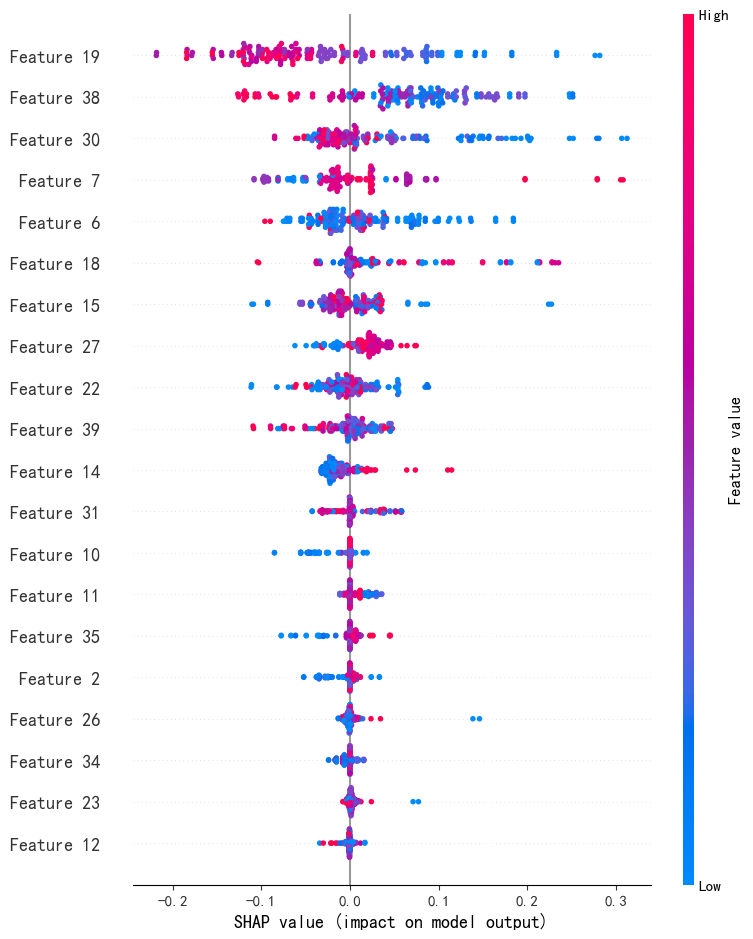

In [47]:
shap.summary_plot(shap_values,features=X_ori_st)
#print(shap_values[0])

# PDP及其图示

In [28]:
'''
转换前的原归一化特征的PDP
'''

ff = Trans_response(Best_read_model, "6Dgp_6D.pickle.dat")

for i in (19,30,38,15,39,22,6,27,23):  # 元组中为排列重要性最大的9个特征的位置索引（列数）
    y_PDP = sigle_PDP(ff.f_trans, X_ori_st, i)
    file = './PDPs/PDP_of_%s.csv'%i
    np.savetxt(file,y_PDP,delimiter=',')


In [20]:
'''保存代码示例'''
#np.savetxt('PDP_of_0.csv',y_PDP,delimiter=',')

'保存代码示例'

In [48]:
''' 读原始的真实样本特征 '''
rawData_True = pd.read_excel('data83.xlsx')
true_samp_feat = np.array(rawData_True.iloc[:,1:-1])

In [60]:
inputData.shape

(600, 40)

********* 0 *********
********* 1 *********
********* 2 *********
********* 3 *********
********* 4 *********
********* 5 *********
********* 6 *********
********* 7 *********
********* 8 *********


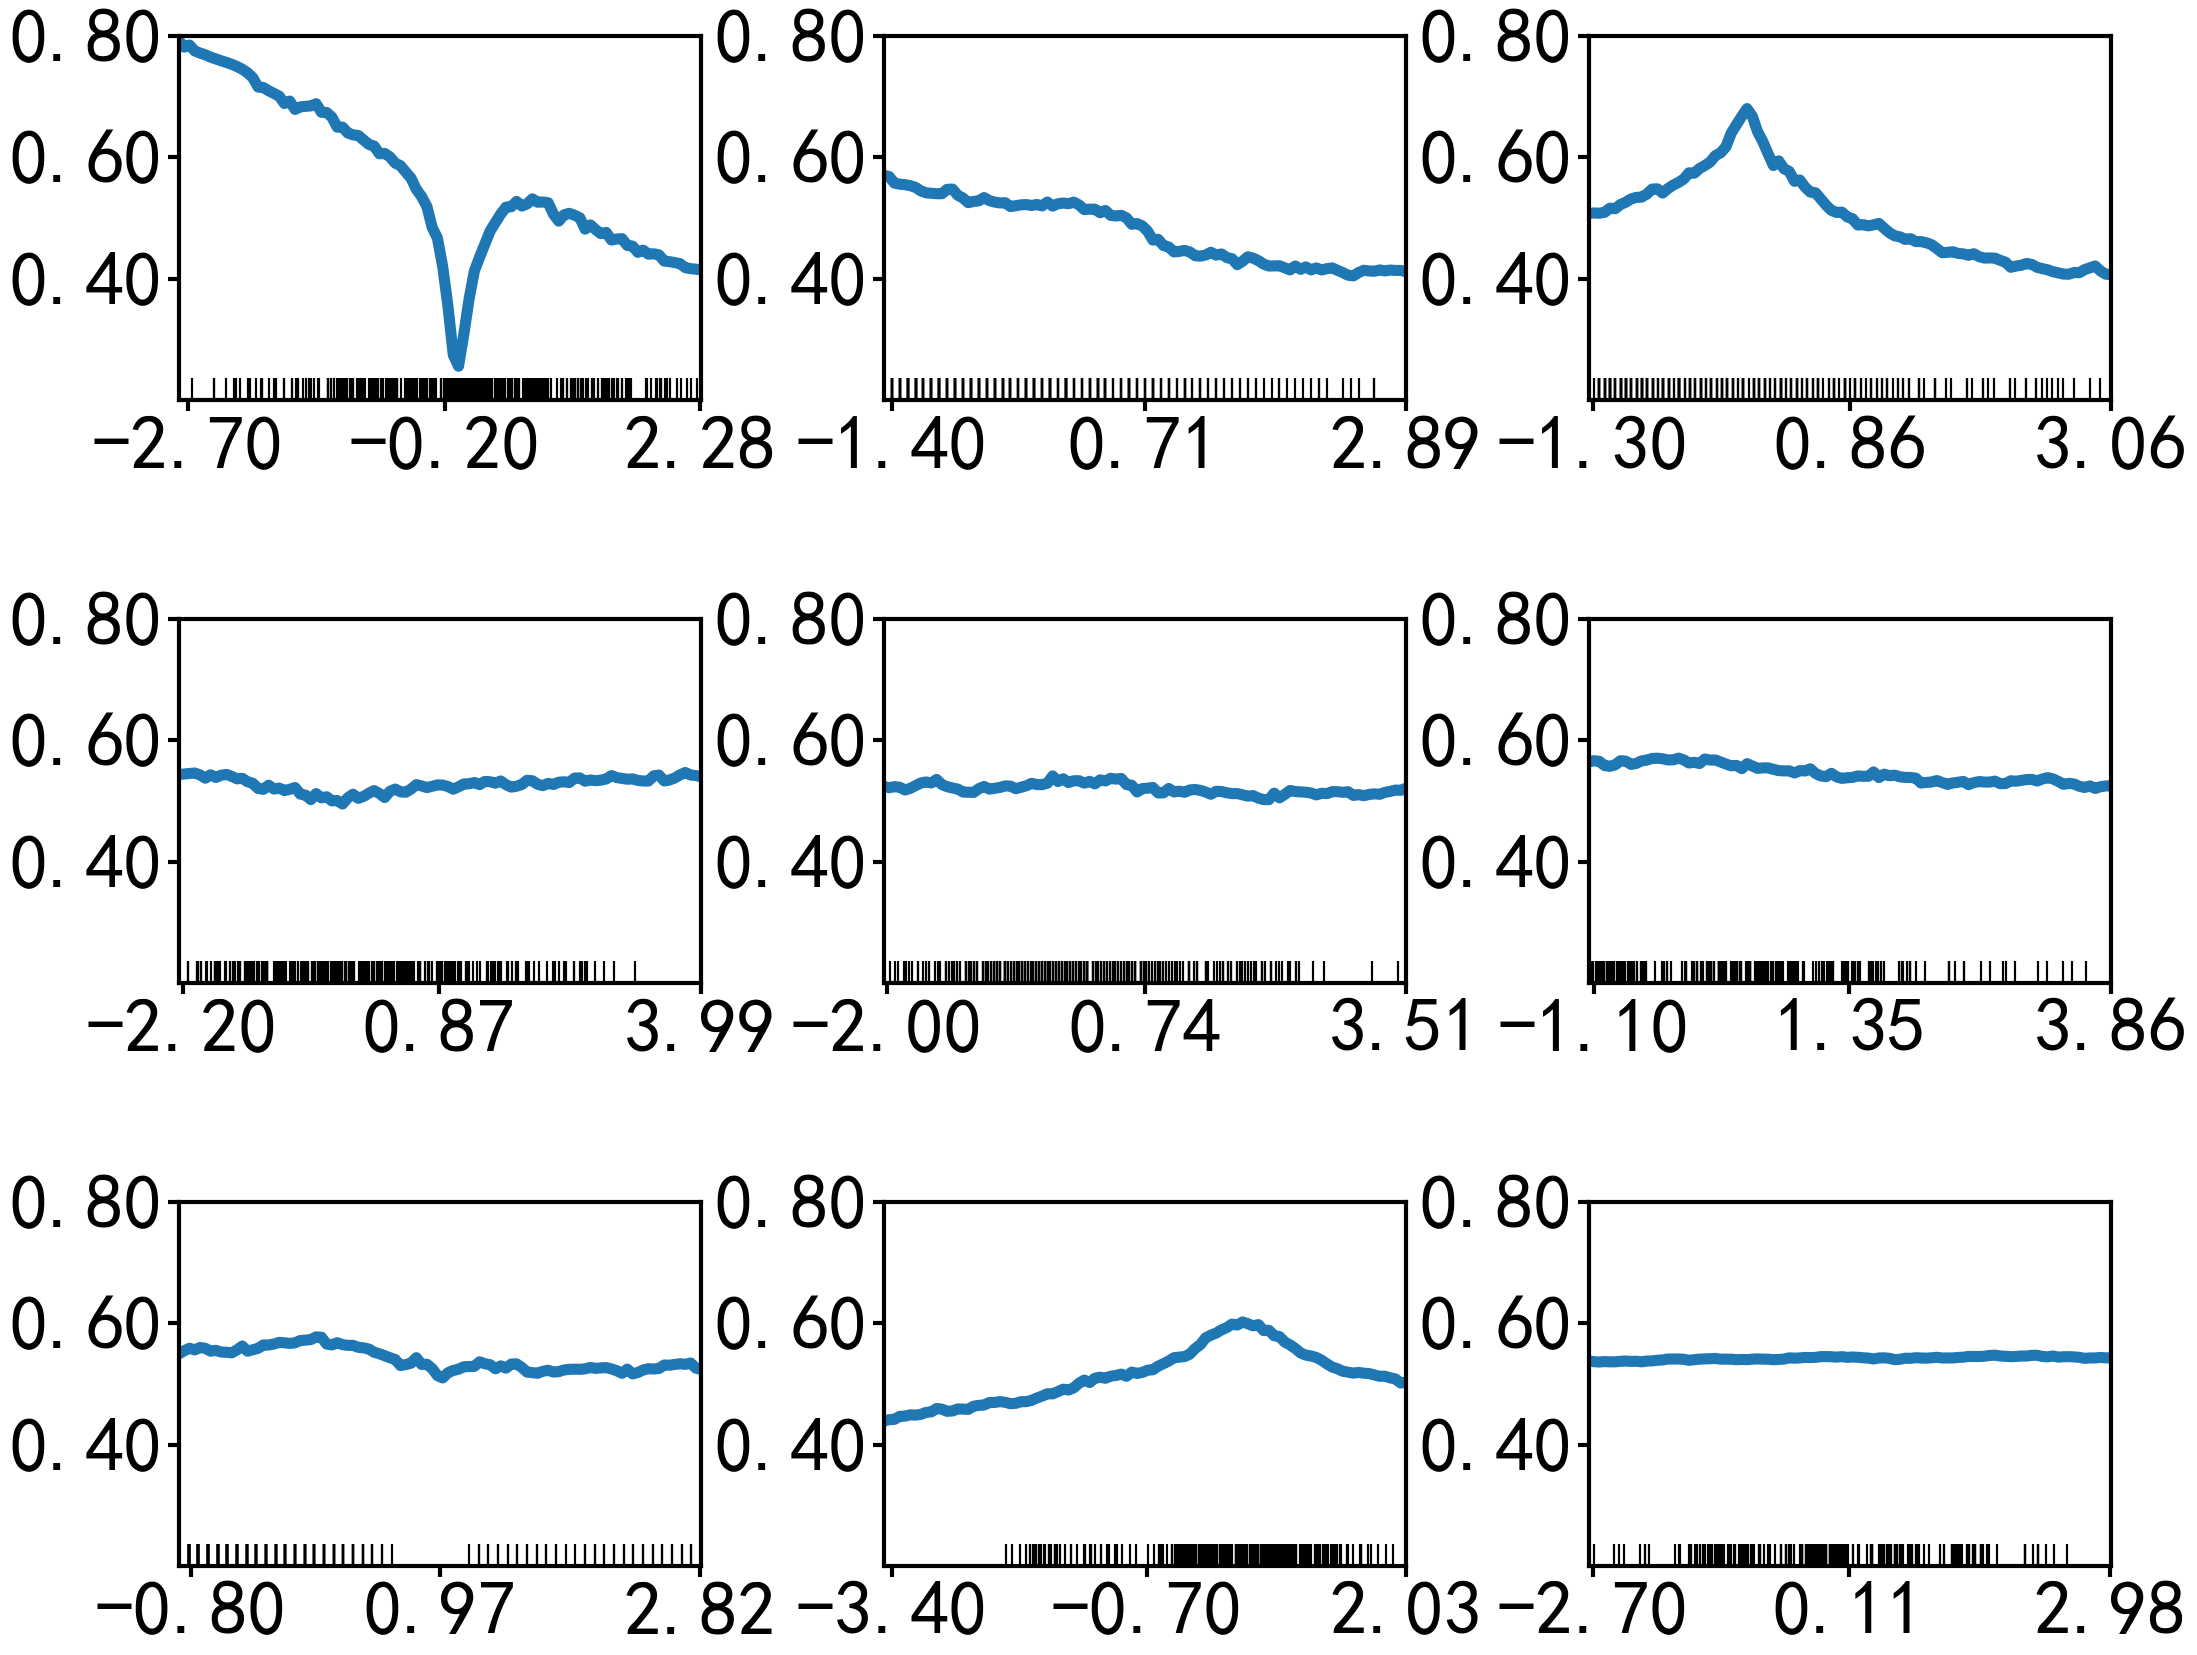

In [179]:
import matplotlib
matplotlib.rcParams['axes.unicode_minus']=False

k=0
X_ind_name = ("","","","","","","","","" )

# X_ind_name = ("$d_{\mathrm{band}^{+}}$",r"$r-$","$r_{\mathrm{v}}-$",r"${\varepsilon}_{+}$","$r_{\mathrm{v+}}$","${\epsilon}_{\mathrm{HOMO-}}$",
#             "$N_{\mathrm{men-}}$","${\epsilon}_{\mathrm{LUMO+}}$","${\epsilon}_{\mathrm{HOMO+}}$" )

plt.figure(figsize=(23,18))
plt.subplots_adjust(left=0.09,bottom=0.1,top=0.95,right=0.93,hspace=0.60,wspace=0.35)

for i,filename in enumerate((19,30,38,15,39,22,6,27,23)):
    y_PDP = np.loadtxt( './PDPs/PDP_of_%s.csv'%filename, delimiter=',')
    plt.subplot(3,3,i+1)
    bwith = 3 #边框宽度设置为2
    ax = plt.gca()#获取边框
    #ax.spines['top'].set_color('red')  # 设置上‘脊梁’为红色
    #ax.spines['right'].set_color('none')  # 设置右‘脊梁’为无色
    ax.spines['bottom'].set_linewidth(bwith)
    ax.spines['left'].set_linewidth(bwith)
    ax.spines['top'].set_linewidth(bwith)
    ax.spines['right'].set_linewidth(bwith)
    #plt.grid( color = 'black',linestyle='-.',linewidth = 1)
    #print('*'*50+'%s'%line_)
    
    xmin = np.min(inputData[:,filename])
    xmax = np.max(inputData[:,filename])
    
    plt.ylim(0.2,0.80)
    plt.xlim(xmin,xmax)
    plt.xticks(ticks=np.linspace(xmin,xmax,3).astype('<U4').astype('float'),fontsize=55)
    plt.yticks(ticks=np.linspace(0.4,0.80,3),labels=('0.40','0.60','0.80'),fontsize=55)
    plt.tick_params(width=3,length=8)
    plt.title(X_ind_name[i],y=-0.268,fontdict={'fontsize':50,})
    
    plt.plot(np.linspace(xmin,xmax,len(y_PDP)),y_PDP,linewidth=8)
    plt.scatter(inputData[:,filename],[0.2]*len(inputData[:,filename]),marker="|",c='k',s=1000)
    print('********* %i *********'%i)
    i += 1
#plt.show()
plt.savefig('./C_O_PDP.png',dpi = 1200)
    
 

# 双向PDP

In [30]:
'''一般列表（Excel, Origin, etc.) '''
'''双向PDP '''

# *** index2应当比index1大 *** <<<<

#for couple in ((19,38),(19,27)):
for couple in ((19,30),(19,38),(19,27),(19,15),(19,39),(30,38),(30,15),(30,39)):
    ff = Trans_response(Best_read_model, "6Dgp_6D.pickle.dat")
    y_PDP = multi_PDP(ff.f_trans, X_ori_st, *couple, N_grid=50, output_format='list')
    f_name = './Double_PDPs/muti_PDP_%s_%s.csv'%(couple[0],couple[1])
    np.savetxt(f_name,y_PDP,delimiter=',')
    print('The feature pair %s was successfully saved in %s'%(couple, f_name))


The feature pair (19, 30) was successfully saved in ./Double_PDPs/muti_PDP_19_30.csv
The feature pair (19, 38) was successfully saved in ./Double_PDPs/muti_PDP_19_38.csv
The feature pair (19, 27) was successfully saved in ./Double_PDPs/muti_PDP_19_27.csv
*** WARNING: the input index1 > index2, their indexes will be exchanged ***
The feature pair (19, 15) was successfully saved in ./Double_PDPs/muti_PDP_19_15.csv
The feature pair (19, 39) was successfully saved in ./Double_PDPs/muti_PDP_19_39.csv
The feature pair (30, 38) was successfully saved in ./Double_PDPs/muti_PDP_30_38.csv
*** WARNING: the input index1 > index2, their indexes will be exchanged ***
The feature pair (30, 15) was successfully saved in ./Double_PDPs/muti_PDP_30_15.csv
The feature pair (30, 39) was successfully saved in ./Double_PDPs/muti_PDP_30_39.csv


In [19]:
y_PDP.shape

(60, 60)

In [31]:
'''为matplotlib包的3D图准备的输出格式'''
#
feature_pairs = ((19,30),(19,38),(19,27),(19,15),(19,39),(30,38),(30,15),(30,39))

PDPs = list()

for couple in feature_pairs:
    ff = Trans_response(Best_read_model, "6Dgp_6D.pickle.dat")
    y_PDP = multi_PDP(ff.f_trans, X_ori_st, *couple, N_grid=50, output_format='matrix')
    PDPs.append(y_PDP)
    print('The feature pair %s'%(couple,))
    

The feature pair (19, 30)
The feature pair (19, 38)
The feature pair (19, 27)
*** WARNING: the input index1 > index2, their indexes will be exchanged ***
The feature pair (19, 15)
The feature pair (19, 39)
The feature pair (30, 38)
*** WARNING: the input index1 > index2, their indexes will be exchanged ***
The feature pair (30, 15)
The feature pair (30, 39)


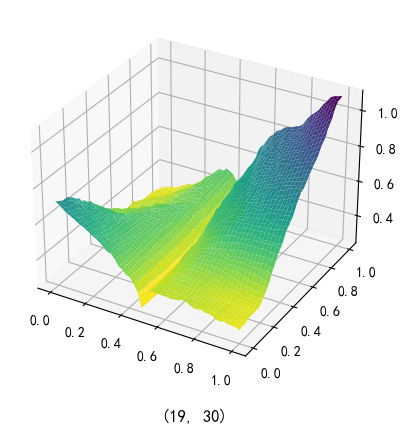

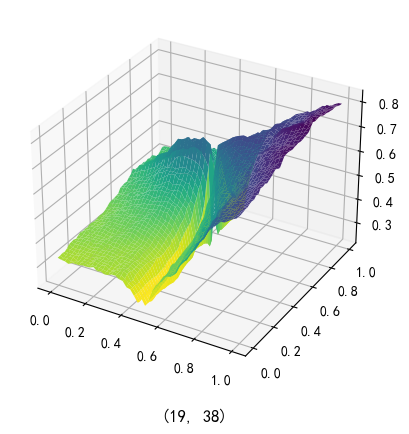

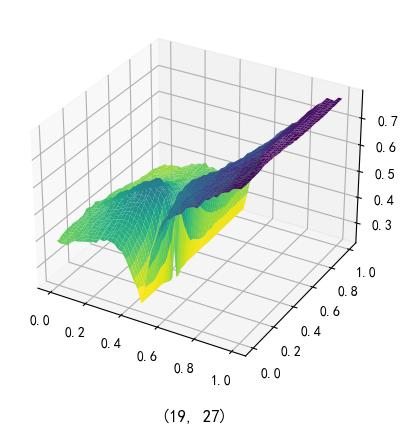

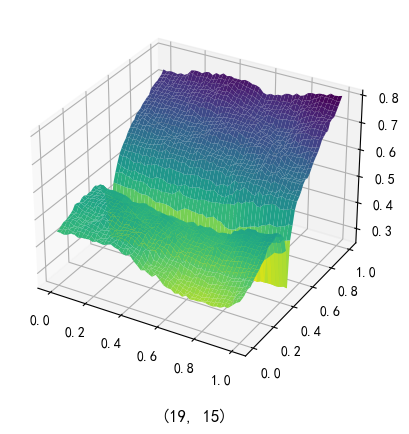

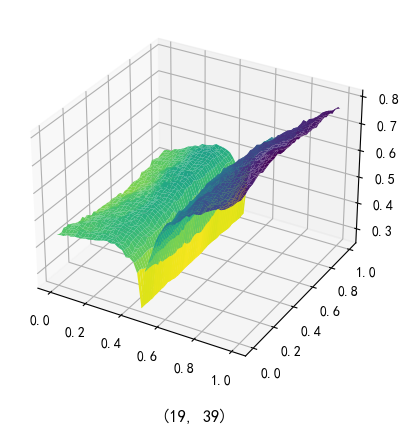

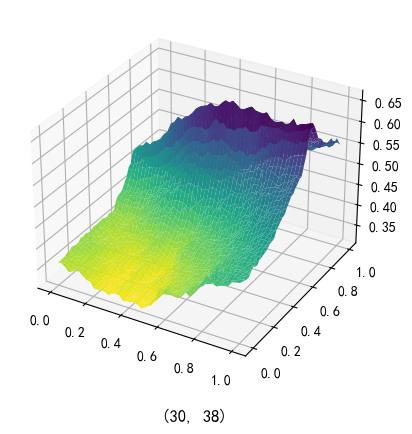

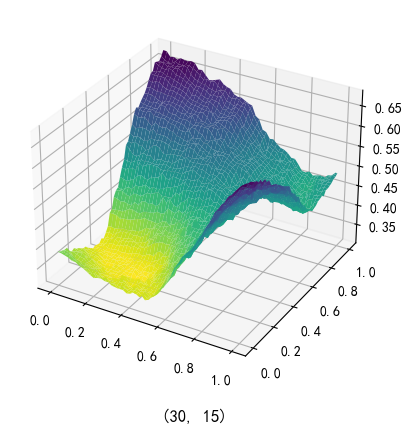

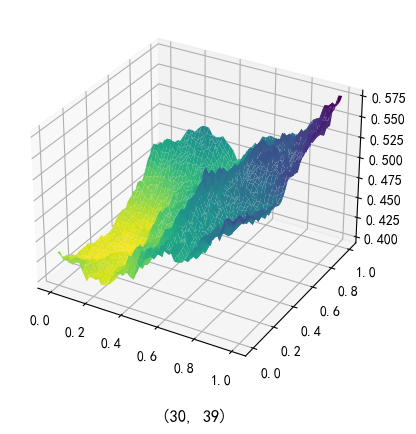

In [32]:

for i,z_PDP in enumerate(PDPs):
    N_grid = len(z_PDP)
    x = np.linspace(0,1,N_grid)
    y = np.linspace(0,1,N_grid)
    x,y = np.meshgrid(x,y)
    fig1 = plt.axes(projection='3d',)
    fig1.plot_surface(x,y,z_PDP,cmap=plt.cm.viridis_r)
    plt.title(str(feature_pairs[i]),y = -0.15)
    plt.show()


# 排列重要性及其图示

In [ ]:
'''permutation_importance'''
'''model=GBR(learning_rate=0.08, max_depth=6, n_estimators=600)
model.fit(X_opt,y_train)
result = permutation_importance(Best_read_model, X_opt, y_train,n_repeats=10, random_state=42) 
result.importances_mean
result.importances_std
np.savetxt('permutation_importance.csv',result.importances_mean,delimiter=',')'''

In [ ]:
'''permutation_importance_ppx'''
'''importlib.reload(ppx)
# model=XGBR(learning_rate=0.069, n_estimators=1200, max_depth=10)
# model.fit(X_opt,y_train)
permut_importance =ppx.Trans_importance(Best_read_model,repeats=100,seeds=10)
permut_importance.permut_imp(X_all_minmax,y_raw,X_name_,X_opt_name)# 归一化之后的X,Y
# print(X_straw_,"\n",y_raw,"\n",X_name_,"\n",X_opt_name)
print(X_opt_name)
permut_importance.importance_MSE
permut_importance.importance_R2
print(permut_importance.R2_std)
print(permut_importance.MSE_std)
np.savetxt('permutation_importance_ppx.csv',permut_importance.importance_R2,delimiter=',')'''

In [7]:
'''
转换前的原归一化特征的排列重要性
'''
ori_importance = Trans_importance(Best_read_model, repeats=100, seeds=16516)
ori_importance.permut_imp(X_ori_st, y_raw, "6Dgp_6D.pickle.dat")

In [8]:
X_ori_name = np.array(standData.columns)
X_ori_name = X_ori_name[1:-1]
importance = ori_importance.importance_MSE
args = np.argsort(importance,)

print(args, X_ori_name[args], '\n', importance[args])
#print(args[-14:], importance[37])

[ 0 32 31 35 29 28 25 21 20 36 18 33 16 17 34  1 11 10  9  8  7  2  3 13
  4  5 37 24 12 26 14 23 27  6 22 39 15 38 30 19] ['Z_1' 'Rp_1' 'R+' 'Rp+' 'R_2' 'R_1' 'LUMO_2' 'HOMO_2' 'HOMO_1' 'Rv_1'
 'dband_' 'Rp_2' 'dband_1' 'dband_2' 'Rp_' 'Z_2' 'X+' 'X_' 'X_2' 'X_1'
 'Nmen+' 'Z_' 'Z+' 'ε_2' 'Nmen_1' 'Nmen_2' 'Rv_2' 'LUMO_1' 'ε_1' 'LUMO_'
 'ε_' 'HOMO+' 'LUMO+' 'Nmen_' 'HOMO_' 'Rv+' 'ε+' 'Rv_' 'R_' 'dband+'] 
 [7.41153829e-22 7.41153829e-22 7.41153829e-22 7.41153829e-22
 7.41153829e-22 7.41153829e-22 7.41153829e-22 7.41153829e-22
 7.41153829e-22 7.41153829e-22 7.41153829e-22 7.41153829e-22
 7.41153829e-22 7.41153829e-22 7.41153829e-22 7.41153829e-22
 7.41153829e-22 7.41153829e-22 7.41153829e-22 7.41153829e-22
 7.41153829e-22 7.41153829e-22 7.41153829e-22 7.41153829e-22
 7.41153829e-22 7.41153829e-22 2.35117754e-04 3.16430694e-04
 1.19568710e-03 1.24696429e-03 3.37420255e-03 3.64130872e-03
 2.35065709e-02 3.90624382e-02 3.91882222e-02 4.55112377e-02
 5.70867131e-02 5.85013662e-02 7.07051037

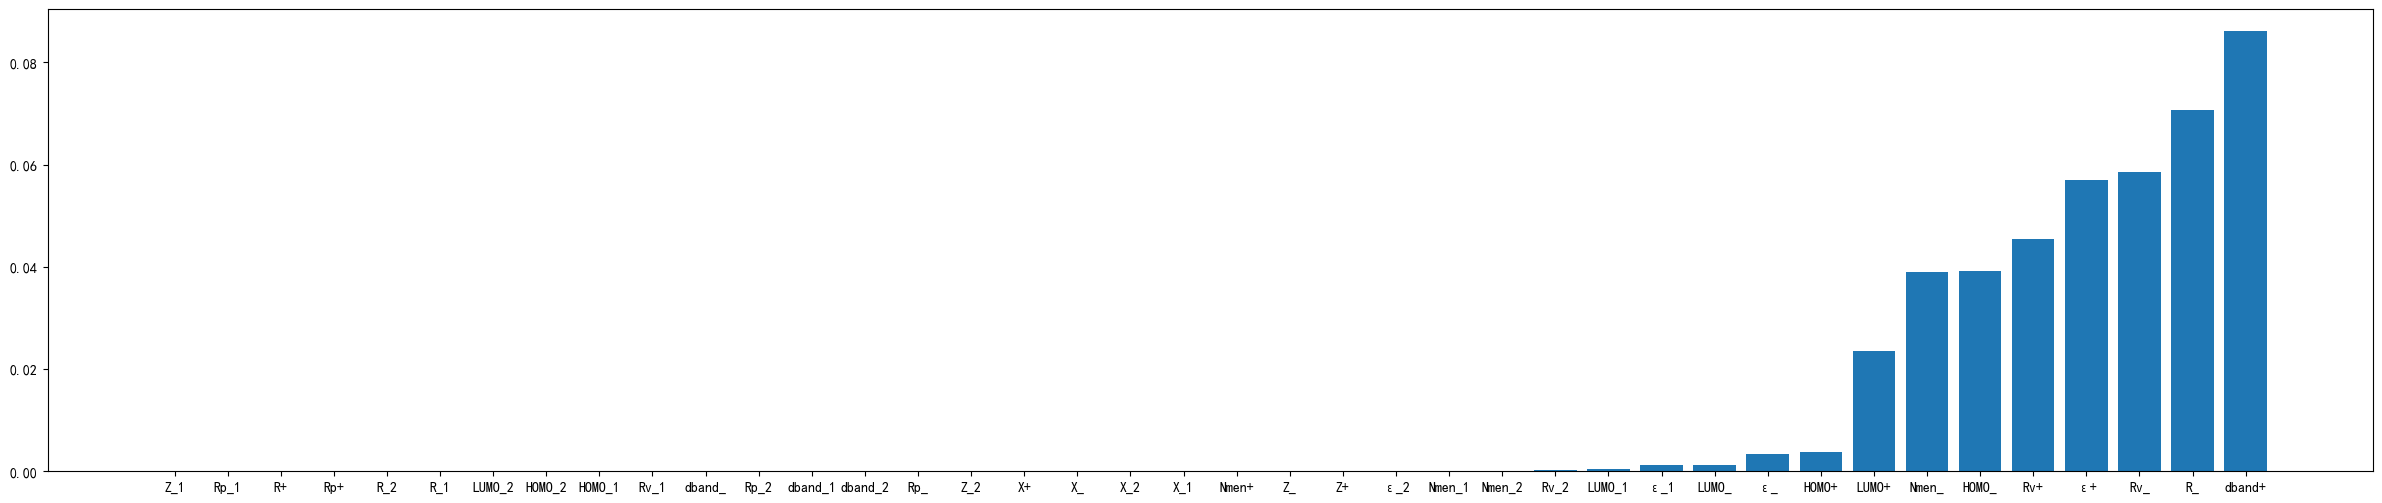

In [9]:

import matplotlib.pyplot as plt

plt.figure(figsize=(30,6))
plt.bar(X_ori_name[args], importance[args])
plt.show()

In [10]:
np.savetxt("importance_E.csv",importance,delimiter=',')

# 预测

In [4]:
'''general_pred'''
X_unlabeled, X_unlabeled_name, y_unlabeled_name=ppx.Read('GP_6D_10.csv').unlabeled_data()
#print(X_unlabeled)
X_general_opt = X_unlabeled
y_general_pred = Best_read_model.predict(X_general_opt)
data = np.loadtxt('true10.csv',dtype='str',delimiter=',')
#number = data.split()
y_DFT = np.array(data[1:,1],dtype=float)
r2_ = r2_score(y_DFT, y_general_pred)
MAE_ = mean_absolute_error(y_DFT, y_general_pred)
RMSE_ = (mean_squared_error(y_DFT, y_general_pred))**0.5
print('r2_ = %s, MAE_ = %s, RMSE_ = %s\n'%(r2_, MAE_, RMSE_))


for i,yt in enumerate(y_DFT):
    print('%f , %f'%(yt,y_general_pred[i]))

print(y_general_pred)
print(y_DFT)
#np.savetxt('y_general_47.csv',y_general_pred,delimiter=',')

提示：返回的X是以样本为行、特征为列的矩阵；y是样本的标签组成的一维数组
r2_ = 0.8589374660499124, MAE_ = 0.07243498503465366, RMSE_ = 0.09345602095132034

0.300000 , 0.352631
0.430000 , 0.365979
0.290000 , 0.241975
0.530000 , 0.683944
0.560000 , 0.346298
0.370000 , 0.344218
0.180000 , 0.233708
1.040000 , 1.036593
0.250000 , 0.169287
0.130000 , 0.108033
0.300000 , 0.354360
0.430000 , 0.385095
0.290000 , 0.248708
0.530000 , 0.670787
0.560000 , 0.346298
0.370000 , 0.342795
0.180000 , 0.226913
1.040000 , 1.098955
0.250000 , 0.169287
0.130000 , 0.108033
[0.35263071 0.36597935 0.24197451 0.68394442 0.34629761 0.34421755
 0.23370775 1.03659344 0.16928716 0.1080328  0.3543602  0.38509469
 0.24870835 0.67078685 0.34629761 0.34279498 0.2269131  1.09895469
 0.16928716 0.1080328 ]
[0.3  0.43 0.29 0.53 0.56 0.37 0.18 1.04 0.25 0.13 0.3  0.43 0.29 0.53
 0.56 0.37 0.18 1.04 0.25 0.13]


In [11]:
print(Best_read_model)

GradientBoostingRegressor(learning_rate=0.06999999999999999, n_estimators=800)


In [12]:
np.savetxt('y_general_10.csv',y_general_pred,delimiter=',')

In [13]:
'''Predict the unlabeled data'''
X_unlabeled, X_unlabeled_name, y_unlabeled_name=ppx.Read('GP_6D_600.csv').unlabeled_data()
print(X_unlabeled)
X_pred_opt = X_unlabeled
y_pred= Best_read_model.predict(X_pred_opt)
print(y_pred)

提示：返回的X是以样本为行、特征为列的矩阵；y是样本的标签组成的一维数组
[[0.960603953 4.522672393 3.980805655 2.977626436 6.697483703 1.953776975]
 [-1.420631777 0.433502134 0.527164953 -1.489467303 -0.290147342
  1.516874006]
 [-0.040201139 3.96716456 4.518003601 0.418455111 1.056714095 3.114966488]
 ...
 [-17.06875466 -34.96155437 -23.41811876 -23.3767083 -8.63195403
  -13.02594212]
 [-22.49497714 -49.64311266 -34.81767314 -34.41793316 -12.83575543
  -21.0604374]
 [-21.342129 -49.7223174 -33.96466545 -38.90909243 -11.29319605
  -25.19303498]]
[0.22047923 0.46835663 0.35550178 0.12073514 0.49992155 0.24197451
 0.42062109 1.10938483 0.17015659 0.2899219  0.28999015 0.24994051
 0.72963701 0.598928   0.68394442 1.20995617 0.85053387 0.22038273
 0.59907744 0.72974147 0.30008879 0.82837718 0.55932117 0.35952124
 0.96669834 0.34421755 0.3102191  0.65609606 0.72007385 0.13020888
 0.49076145 0.16928716 0.52831041 0.31084528 0.16991785 0.5201897
 0.71880277 0.81997164 0.50104629 0.99961338 0.89016442 0.77938842
 0.71998809 0.60

In [14]:
np.savetxt('y_pred_600.csv',y_pred,delimiter=',')

In [15]:
# importlib.reload(ppx)
test = ppx.US(5, GBR(learning_rate=0.06999999999999999, n_estimators=800),n_iter=100)# US= uncertainty   16代表前16个不确定性最大的催化剂
test.run(X_straw, y_train, X_pred_opt, split_size=0.1, n_group=2)
print(y_train.shape)
print(X_pred_opt.shape)

Varibles initialized, entering main loop...

***iteration 1  train_MSE = 1.2979131154324846e-07  val_MSE = 0.024140329630219795
***iteration 2  train_MSE = 1.5765999482536587e-07  val_MSE = 0.03594476698248335
***iteration 3  train_MSE = 9.963749635091882e-08  val_MSE = 0.04631074796094417
***iteration 4  train_MSE = 1.2848857030154564e-07  val_MSE = 0.07364799779506792
***iteration 5  train_MSE = 8.058703899241261e-08  val_MSE = 0.06335667249978288
***iteration 6  train_MSE = 1.6090318226409478e-07  val_MSE = 0.09785562691543476
***iteration 7  train_MSE = 1.6687009280330744e-07  val_MSE = 0.06477215840956567
***iteration 8  train_MSE = 1.0694005077973507e-07  val_MSE = 0.02559254910052051
***iteration 9  train_MSE = 8.84312269054029e-08  val_MSE = 0.055627089883942896
***iteration 10  train_MSE = 8.430426674518605e-08  val_MSE = 0.03123403950942615
***iteration 11  train_MSE = 9.684700795436383e-08  val_MSE = 0.044144083057761456
***iteration 12  train_MSE = 1.6846482598079421e-07  v

***iteration 100  train_MSE = 1.5079749415266492e-07  val_MSE = 0.053587575604004255
(166,)
(600, 6)


In [16]:
print('valid mean RMSE = %s\nsampling points uncertainty: %s\nsampling points: %s'%(test.valid_mean_MSE**0.5, test.uncertain_list[test.sampling_args],y_unlabeled_name[test.sampling_args]))

valid mean RMSE = 0.2109907543165645
sampling points uncertainty: [0.12856437 0.13049482 0.14610681 0.14925972 0.16939823]
sampling points: ['Cu_Pd' 'Fe_AuE' 'Ti_Co' 'Nb_Ag' 'Ti_CoE']


In [17]:
np.savetxt('uncertainty_600.csv', test.uncertain_list, delimiter=',')

In [18]:
f = open('uncertainty_600.csv',mode = 'w')
f.write('y_name, pred_mean, uncertainty\n')
for i,val in enumerate(test.uncertain_list):
    f.write('%s, %s, %s\n'%(y_unlabeled_name[i],test.predict_mean[i],test.uncertain_list[i]))
f.close()